Zachary Armand

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn import Linear, ReLU, Sequential

In [285]:
#pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Load Data and Create Dataset

In [220]:
input_values = torch.load('input_values.pth')
target_values = torch.load('target_values.pth')

Dataset and dataloaders are used for both models.

In [221]:
# Create Dataset
dataset = TensorDataset(input_values, target_values)

# Split into test and train data
train_dataset, test_dataset = random_split(dataset, [0.85, 0.15])
train_dataset, valid_dataset = random_split(train_dataset, [0.82, 0.18])
print(f"Train: {len(train_dataset)/len(dataset)*100:.1f}%, Test: {len(test_dataset)/len(dataset)*100:.1f}%, Valid: {len(valid_dataset)/len(dataset)*100:.1f}%")

Train: 69.7%, Test: 15.0%, Valid: 15.3%


# Modeling

In [222]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using:", DEVICE)

Using: mps


In [223]:
def train_model(model, optimizer, dataloader, device):
    model.train()
    criterion = nn.MSELoss()
    epoch_loss = 0
    for inputs, targets in dataloader:
        # Send to the right device
        inputs, targets = inputs.to(device), targets.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)[:, 0]
        # Calculate and log loss
        loss = torch.sqrt(criterion(outputs, targets))
        # Backwards pass and step
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()*inputs.size(0)  # loss * batch size
    return epoch_loss / len(dataloader.dataset)  # average loss 

def evaluate_model_RSME(model, dataloader, device):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():  # Disable gradients for evaluation
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)  # Ensure test inputs are on the same device
            # Make prediction
            outputs = model(inputs)[:, 0]
            # Get loss
            loss = torch.sqrt(criterion(outputs, targets))  # sqrt(MSE)
            total_loss += loss.item()*inputs.size(0)  # loss * batch size
    return total_loss / len(dataloader.dataset)  # average loss

def evaluate_model_MAE(model, dataloader, device):
    model.eval()
    criterion = nn.L1Loss()
    total_loss = 0
    with torch.no_grad():  # Disable gradients for evaluation
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)  # Ensure test inputs are on the same device
            # Make prediction
            outputs = model(inputs)[:, 0]
            # Get loss
            loss = criterion(outputs, targets)  # MAE
            total_loss += loss.item()*inputs.size(0)  # loss * batch size
    return total_loss / len(dataloader.dataset)  # average loss

## Simple Linear model

### MLP hyperparameter tuning

In [224]:
class SimpleNet(nn.Module):
    def __init__(self, in_features=12, hidden_features=24, num_layers=3, dropout=0.0):
        super().__init__()
        
        layers = []        
        # Hidden layers (loop to create multiple layers)
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_features, hidden_features))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        # Combine all layers into a sequential model
        self.mlpnet = nn.Sequential(
            # Input layer
            nn.Linear(in_features, hidden_features),
            nn.ReLU(),
            nn.Dropout(dropout),
            # Loop of layers
            *layers,            
            # Output layer
            nn.Linear(hidden_features, 1),
        )

    def forward(self, x):
        x = self.mlpnet(x)
        return x.squeeze()


In [282]:
testing_params = {
    'batch_size': [32, 64, 128],
    'lr': [0.001, 0.0001, 0.00001],
    'hidden_size': [12, 48, 72],
    'mlp_dropout': [0.0, 0.25, 0.5],
    'weight_decay': [0.0, 1e-5, 1e-4, 1e-3, 1e-2]
}

In [283]:
results = {}

# Create a list of all parameter combinations
param_combinations = [(batch_size, lr, hidden_size, mlp_dropout, weight_decay)
                      for batch_size in testing_params['batch_size']
                      for lr in testing_params['lr']
                      for hidden_size in testing_params['hidden_size']
                      for mlp_dropout in testing_params['mlp_dropout']
                      for weight_decay in testing_params['weight_decay']
                      ]

# Initialize tqdm progress bar to track progress through 144 iterations
pbar = tqdm(param_combinations, desc="Training Models", total=len(param_combinations))

num_epochs = 30

# Iterate over parameter combinations
for i, (batch_size, lr, hidden_size, mlp_dropout, weight_decay) in enumerate(pbar):

    # Turn into Dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)


    simple_baseball_mlp = SimpleNet(hidden_features=hidden_size, dropout=mlp_dropout).to(DEVICE)
    
    #print(f'Batch size: {batch_size}, hidden size: {hidden_size}, lr: {lr}, dropout: {mlp_dropout}')
    # Print trainable parameters
    trainable_params = sum(p.numel() for p in simple_baseball_mlp.parameters() if p.requires_grad)
    #print(f"Trainable parameters: {trainable_params:,}")

    # Optimizer and loss
    optimizer = Adam(simple_baseball_mlp.parameters(), lr=lr, weight_decay=weight_decay)
    loss_func = nn.MSELoss()

    # Params: lr, hidden layers, batch size

    # Training
    log = []
    eval_log = []

    # Training loop
    #pbar = tqdm(range(num_epochs), desc="Training MLP")
    #for epoch in pbar:
    for epoch in range(num_epochs):

        # Get average loss over batches for training
        avg_train_loss = train_model(simple_baseball_mlp, optimizer, train_dataloader, DEVICE)
        log.append(avg_train_loss)
        # Validation loss
        avg_valid_loss = evaluate_model_RSME(simple_baseball_mlp, valid_dataloader, DEVICE)
        eval_log.append(avg_valid_loss)
        
        #pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss, 'Train-Valid': (avg_train_loss-avg_valid_loss)})


    results[i] = [log]
    results[i].append(eval_log)

    # Final output
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    test_accuracy_RSME = evaluate_model_RSME(simple_baseball_mlp, test_dataloader, DEVICE)
    test_accuracy_MAE = evaluate_model_MAE(simple_baseball_mlp, test_dataloader, DEVICE)
    results[i].append(test_accuracy_RSME)
    results[i].append(f'Batch size: {batch_size}, hidden: {hidden_size}, lr: {lr}, dropout: {mlp_dropout}, l2: {weight_decay}\nRSME: {test_accuracy_RSME:.4}')

    #print(f'Test RMSE: {test_accuracy_RSME:.4f}, Test MAE: {test_accuracy_MAE:.4f}')

Training Models:   0%|          | 0/324 [1:18:14<?, ?it/s]


KeyboardInterrupt: 

Evaluate the models, first by lowest RSME

In [272]:
# Get rankings of each model by RSME
mlp_rsmes = np.array([results[i][2] for i in results])
order = mlp_rsmes.argsort()
# Then, pull out the top n models and print their information
n_best = 6
best_models = [(ind.item(), results[ind][3]) for ind in order[0:n_best]]
# Print out index of model in results dictionary and it's parameters
best_models

[(0, 'Batch size: 32, hidden: 12, lr: 0.001, dropout: 0.0\nRSME: 0.3684'),
 (8, 'Batch size: 32, hidden: 48, lr: 0.001, dropout: 0.0\nRSME: 0.376'),
 (20, 'Batch size: 32, hidden: 24, lr: 0.0001, dropout: 0.0\nRSME: 0.3765'),
 (10, 'Batch size: 32, hidden: 48, lr: 0.001, dropout: 0.33\nRSME: 0.3767'),
 (11, 'Batch size: 32, hidden: 48, lr: 0.001, dropout: 0.5\nRSME: 0.3768'),
 (5, 'Batch size: 32, hidden: 24, lr: 0.001, dropout: 0.5\nRSME: 0.3768')]

Then, visualize the best models and make sure they aren't overfitting

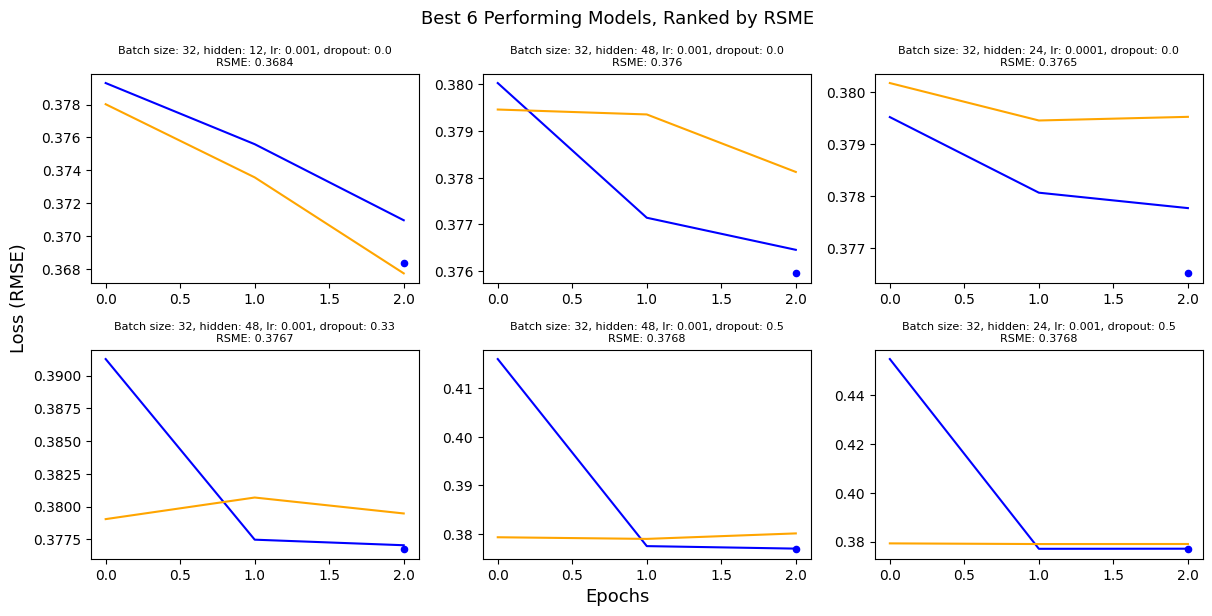

In [274]:
# n_figures = n_best
n_columns = 3
n_rows = int(np.ceil(n_best / n_columns))
fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns * 4, n_rows * 3))
axes = axes.flatten()

for i, model in enumerate(order[0:n_best]):
    axes[i].set_title(results[model][3], size=8)
    axes[i].plot(results[model][0], c='b')
    axes[i].plot(results[model][1], c='orange')
    axes[i].scatter(x=num_epochs-1, y=results[model][2], c='b', s=20)
#plt.legend()
fig.text(0.001, 0.5, 'Loss (RMSE)', ha='center', va='center', rotation='vertical', fontsize=13)
fig.text(0.5, 0.001, 'Epochs', ha='center', va='center', fontsize=13)
plt.suptitle(f"Best {n_best} Performing Models, Ranked by RSME", fontsize=13)
plt.tight_layout()

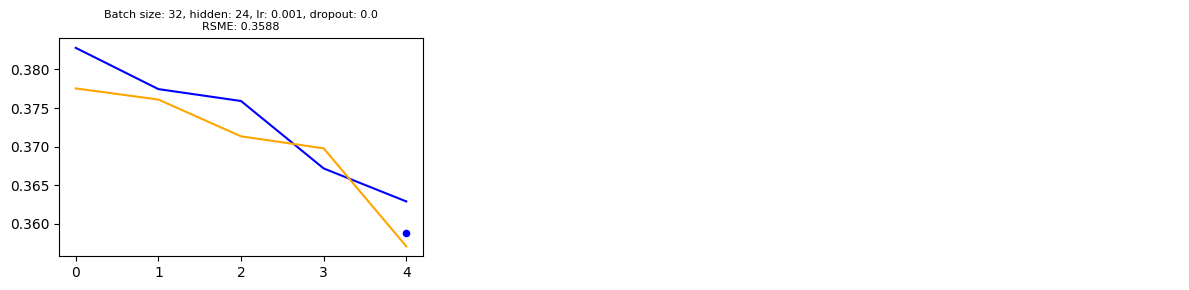

In [ ]:
n_figures = len(results)
n_columns = 3
n_rows = int(np.ceil(n_figures / n_columns))
fig, axes = plt.subplots(n_rows, n_columns, figsize=(n_columns * 4, n_rows * 3))
axes = axes.flatten()

for i in range(n_figures):
    axes[i].set_title(results[i][3], size=8)
    axes[i].plot(results[i][0], c='b')
    axes[i].plot(results[i][1], c='orange')
    axes[i].scatter(x=num_epochs-1, y=results[i][2], c='b', s=20)
for j in range(n_figures, len(axes)):
    axes[j].axis('off')
#plt.legend()
#plt.ylabel('Loss (RMSE)')
#plt.xlabel('Epoch')
plt.tight_layout()

### Final MLP model

Trainable parameters: 5,057


Training MLP: 100%|██████████| 150/150 [23:45<00:00,  9.50s/it, Train loss=0.35, Validation loss=0.352] 


Test RMSE: 0.3549, Test MAE: 0.2728


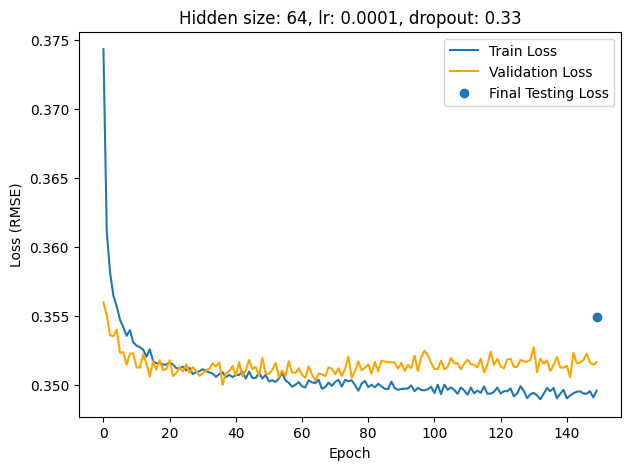

In [551]:
lr = 0.0001
hidden_size = 64
mlp_dropout = 0.33
num_epochs = 150


simple_baseball_mlp = SimpleNet(hidden_features=hidden_size, dropout=mlp_dropout).to(DEVICE)

# Print trainable parameters
trainable_params = sum(p.numel() for p in simple_baseball_mlp.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer and loss
optimizer = Adam(simple_baseball_mlp.parameters(), lr=lr)
loss_func = nn.MSELoss()

# Params: lr, hidden layers, batch size

# Training
log = []
eval_log = []

# Training loop
pbar = tqdm(range(num_epochs), desc="Training MLP")
for epoch in pbar:

    # Get average loss over batches for training
    avg_train_loss = train_model(simple_baseball_mlp, optimizer, MLP_train_dataloader, DEVICE)
    log.append(avg_train_loss)
    avg_valid_loss = evaluate_model_RSME(simple_baseball_mlp, MLP_valid_dataloader, DEVICE)
    eval_log.append(avg_valid_loss)

    # Print loss every 5 epochs
    #if epoch % 5 == 0:
    #print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")
    
    pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss})

# Final output
#print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")
test_accuracy_RSME = evaluate_model_RSME(simple_baseball_mlp, MLP_test_dataloader, DEVICE)
test_accuracy_MAE = evaluate_model_MAE(simple_baseball_mlp, MLP_test_dataloader, DEVICE)

print(f'Test RMSE: {test_accuracy_RSME:.4f}, Test MAE: {test_accuracy_MAE:.4f}')


# Plot loss over time
plt.figure(figsize=(7, 5))
plt.title(f'Hidden size: {hidden_size}, lr: {lr}, dropout: {mlp_dropout}')
plt.ylabel('Loss (RMSE)')
plt.xlabel('Epoch')
plt.plot(log, label='Train Loss')
plt.plot(eval_log, label='Validation Loss', color='orange')
plt.scatter(x=epoch, y=test_accuracy_RSME, label='Final Testing Loss')
plt.legend()

plt.show()

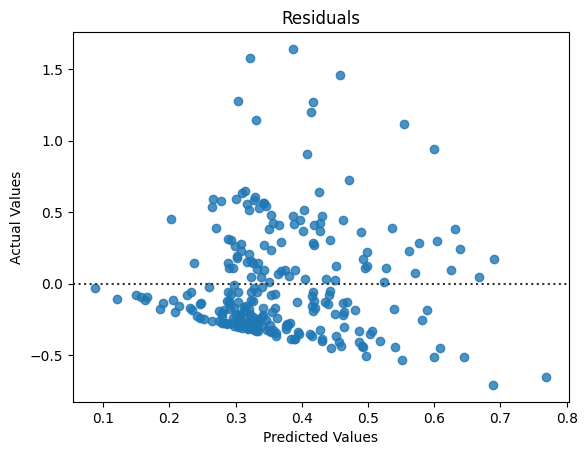

In [552]:
n_samples = 250  

real_ys = [dat[1].item() for i, dat in enumerate(MLP_dataset) if i < n_samples]
mlp_ys = [simple_baseball_mlp(dat[0].to(DEVICE)).item() for i, dat in enumerate(MLP_dataset) if i < n_samples]

plt.title("Residuals")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
sns.residplot(x=mlp_ys, y=real_ys)
plt.show()

### Baseball RNN

A many-to-one RNN

Pad sequences

In [257]:
from torch.nn.utils.rnn import pad_sequence

# Convert the list of numpy arrays to a list of tensors
at_bat_tensors = [torch.tensor(at_bat, dtype=torch.float32) for at_bat in input_vals]

# Pad the sequences - (batch_size, max_sequence_length, 12)
padded_at_bats = pad_sequence(at_bat_tensors, batch_first=True, padding_value=0)  # padding_value=0 for zero padding

In [258]:
# Create Dataset
batch_size = 32
dataset = BaseballDataset(padded_at_bats, rnn_ys)
# Split into test and train data
train_dataset, test_dataset = random_split(dataset, [0.85, 0.15])
train_dataset, valid_dataset = random_split(train_dataset, [0.82, 0.18])
print(f"Train: {len(train_dataset)/len(dataset)*100:.1f}%, Test: {len(test_dataset)/len(dataset)*100:.1f}%, Valid: {len(valid_dataset)/len(dataset)*100:.1f}%")

# Turn into Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Train: 69.7%, Test: 15.0%, Valid: 15.3%


In [378]:
class BaseballRNN_test(torch.nn.Module):
    def __init__(self, input_size, output_size=1, hidden_size=256, fc_hidden_size=256,
                n_layers=1, rnn_type='RNN', bidirectional=False, hidden_init='zero', rnn_dropout=0.2):
        super().__init__()

        self.hidden_size = hidden_size
        self.rnn_type = rnn_type
        self.n_layers = n_layers
        self.hidden_init = hidden_init
        self.rnn_dropout = rnn_dropout


        self.prefc = nn.Linear(input_size, hidden_size)
        self.rnn1 = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=self.n_layers, bidirectional=bidirectional, dropout=self.rnn_dropout)
        self.layernorm_rnn1 = nn.LayerNorm(hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)


    def forward(self, x):

        # Pre RNN Linear Layer
        x = self.prefc(x)
        x = F.dropout(x, self.rnn_dropout)
        
        # Initial hidden states for RNNs
        if self.hidden_init == 'zero':
            h0 = torch.zeros(self.n_layers, x.size(0), self.rnn1.hidden_size, device=x.device)
        elif self.hidden_init == 'rand':
            h0 = torch.randn(self.n_layers, x.size(0), self.rnn1.hidden_size, device=x.device)

        # Send through RNN
        out, hidden = self.rnn1(x, h0)
        # Get output of the last time step
        out = out[:, -1, :]
        out = self.layernorm_rnn1(out)
        out = F.dropout(out, self.rnn_dropout)

        # Send through fully connected layers
        out = self.relu(self.fc1(out))
        F.dropout(out, self.rnn_dropout)
        out = self.fc2(out)

        return out

In [379]:
hyperparameters = {
    'hidden_size': [64, 128, 256],
    'n_layers': [1, 2],
    'learning_rate': [0.001, 0.0001],
    'rnn_dropout': [0.0, 0.25, 0.33, 0.5]
}

Hidden size: 64, n_layers: 1, lr: 0.001, dropout: 0.0
Trainable parameters: 30,145


Training RNN: 100%|██████████| 30/30 [17:02<00:00, 34.08s/it, Train loss=0.337, Validation loss=0.393, Valid Running Slope=0.000989]


Test RMSE: 0.3927, Test MAE: 0.3010


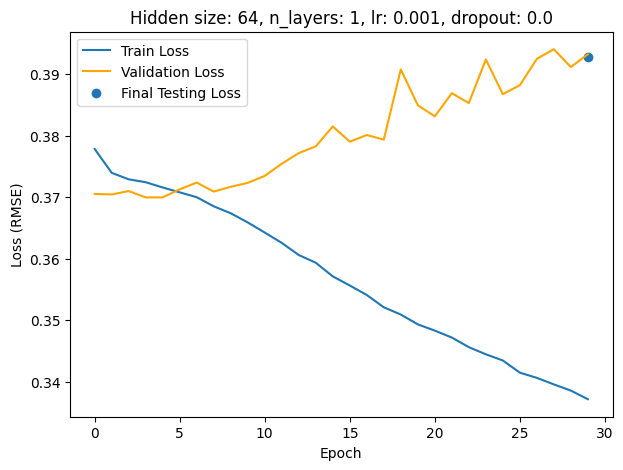

Hidden size: 64, n_layers: 1, lr: 0.001, dropout: 0.25
Trainable parameters: 30,145


Training RNN: 100%|██████████| 30/30 [17:50<00:00, 35.70s/it, Train loss=0.364, Validation loss=0.377, Valid Running Slope=0.000153]


Test RMSE: 0.3810, Test MAE: 0.2935


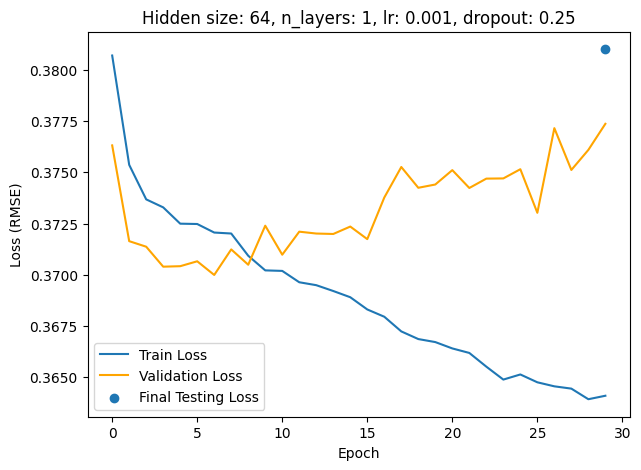

Hidden size: 64, n_layers: 1, lr: 0.001, dropout: 0.33
Trainable parameters: 30,145


Training RNN: 100%|██████████| 30/30 [17:48<00:00, 35.62s/it, Train loss=0.367, Validation loss=0.372, Valid Running Slope=0.000302] 


Test RMSE: 0.3763, Test MAE: 0.2904


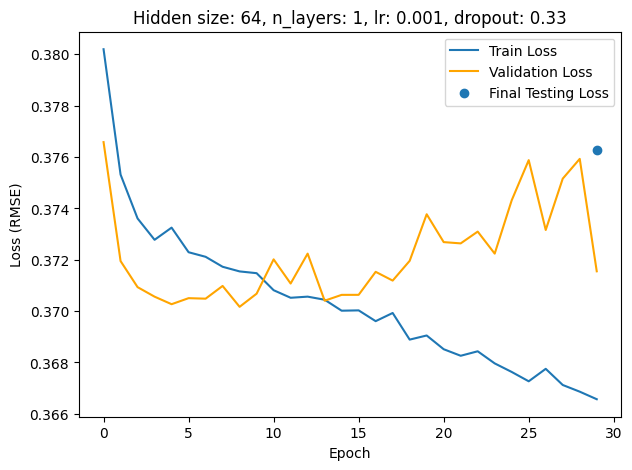

Hidden size: 64, n_layers: 1, lr: 0.001, dropout: 0.5
Trainable parameters: 30,145


Training RNN: 100%|██████████| 30/30 [17:52<00:00, 35.77s/it, Train loss=0.371, Validation loss=0.373, Valid Running Slope=2.56e-5]  


Test RMSE: 0.3749, Test MAE: 0.2898


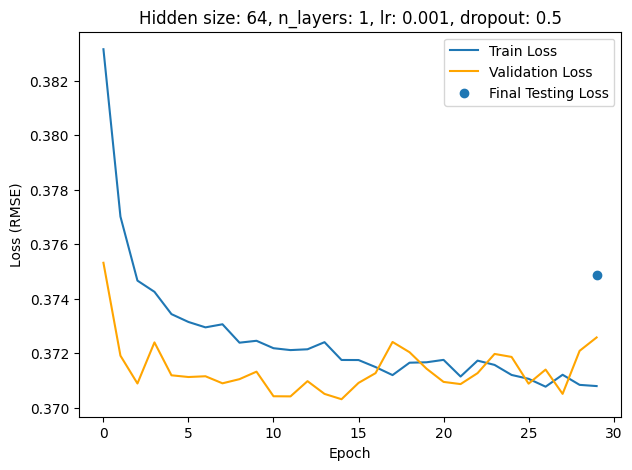

Hidden size: 64, n_layers: 1, lr: 0.0001, dropout: 0.0
Trainable parameters: 30,145


Training RNN: 100%|██████████| 30/30 [16:52<00:00, 33.76s/it, Train loss=0.367, Validation loss=0.372, Valid Running Slope=9.41e-5]  


Test RMSE: 0.3762, Test MAE: 0.2892


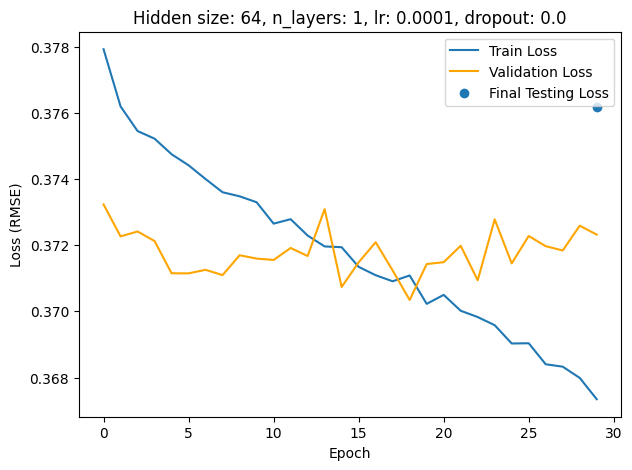

Hidden size: 64, n_layers: 1, lr: 0.0001, dropout: 0.25
Trainable parameters: 30,145


Training RNN: 100%|██████████| 30/30 [17:31<00:00, 35.05s/it, Train loss=0.371, Validation loss=0.371, Valid Running Slope=2.81e-5]  


Test RMSE: 0.3739, Test MAE: 0.2883


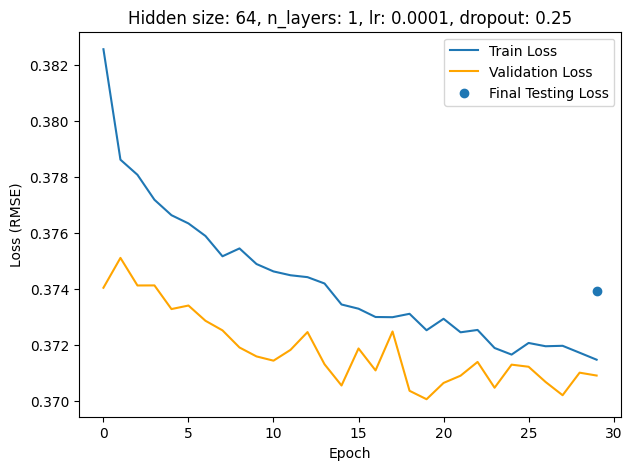

Hidden size: 64, n_layers: 1, lr: 0.0001, dropout: 0.33
Trainable parameters: 30,145


Training RNN: 100%|██████████| 30/30 [17:29<00:00, 35.00s/it, Train loss=0.372, Validation loss=0.37, Valid Running Slope=-3.34e-5]  


Test RMSE: 0.3746, Test MAE: 0.2887


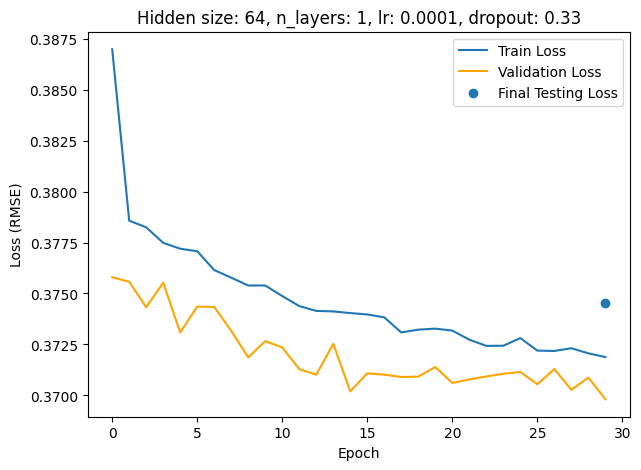

Hidden size: 64, n_layers: 1, lr: 0.0001, dropout: 0.5
Trainable parameters: 30,145


Training RNN: 100%|██████████| 30/30 [17:29<00:00, 34.99s/it, Train loss=0.372, Validation loss=0.37, Valid Running Slope=3.85e-5]   


Test RMSE: 0.3747, Test MAE: 0.2873


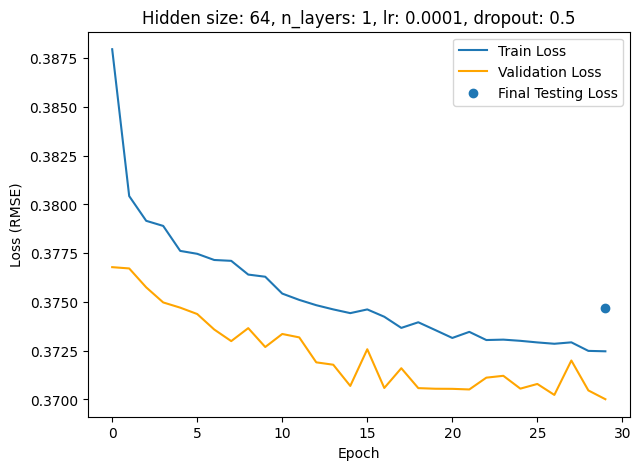

Hidden size: 64, n_layers: 2, lr: 0.001, dropout: 0.0
Trainable parameters: 55,105


Training RNN: 100%|██████████| 30/30 [28:32<00:00, 57.08s/it, Train loss=0.312, Validation loss=0.408, Valid Running Slope=0.000697]


Test RMSE: 0.4068, Test MAE: 0.3063


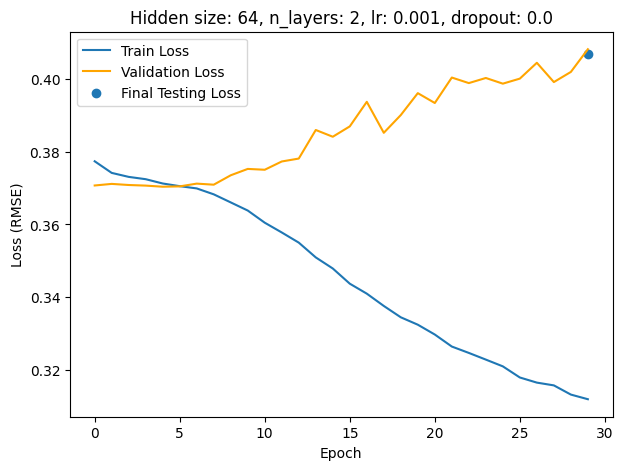

Hidden size: 64, n_layers: 2, lr: 0.001, dropout: 0.25
Trainable parameters: 55,105


Training RNN: 100%|██████████| 30/30 [30:00<00:00, 60.01s/it, Train loss=0.365, Validation loss=0.374, Valid Running Slope=-2.78e-5] 


Test RMSE: 0.3766, Test MAE: 0.2907


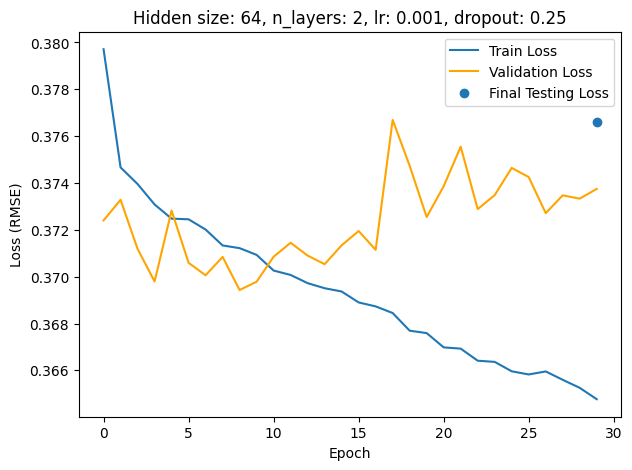

Hidden size: 64, n_layers: 2, lr: 0.001, dropout: 0.33
Trainable parameters: 55,105


Training RNN: 100%|██████████| 30/30 [29:35<00:00, 59.18s/it, Train loss=0.368, Validation loss=0.374, Valid Running Slope=0.000255] 


Test RMSE: 0.3757, Test MAE: 0.2864


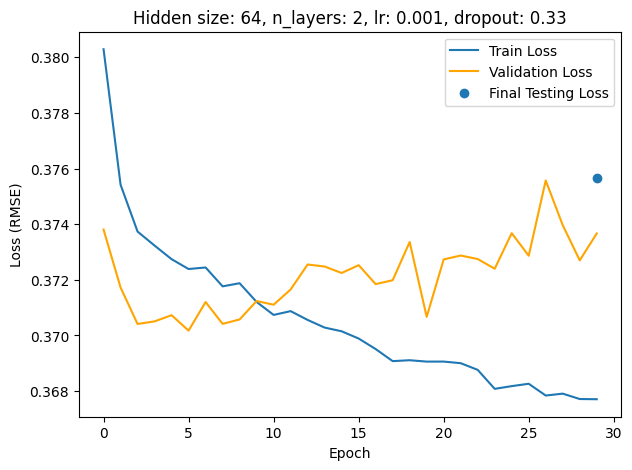

Hidden size: 64, n_layers: 2, lr: 0.001, dropout: 0.5
Trainable parameters: 55,105


Training RNN: 100%|██████████| 30/30 [30:00<00:00, 60.01s/it, Train loss=0.372, Validation loss=0.371, Valid Running Slope=-5.99e-5] 


Test RMSE: 0.3751, Test MAE: 0.2897


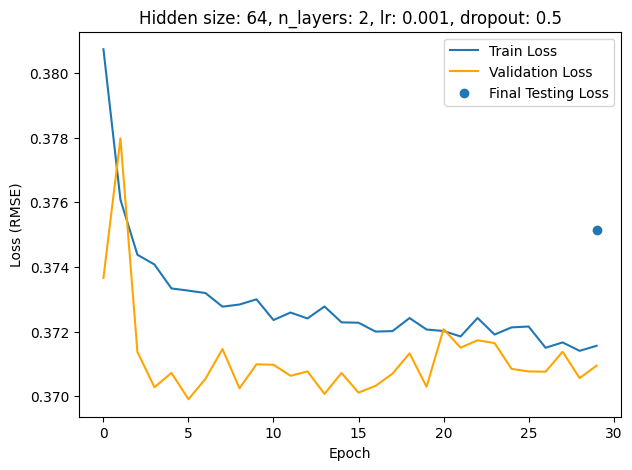

Hidden size: 64, n_layers: 2, lr: 0.0001, dropout: 0.0
Trainable parameters: 55,105


Training RNN: 100%|██████████| 30/30 [28:34<00:00, 57.15s/it, Train loss=0.365, Validation loss=0.376, Valid Running Slope=0.000216] 


Test RMSE: 0.3784, Test MAE: 0.2974


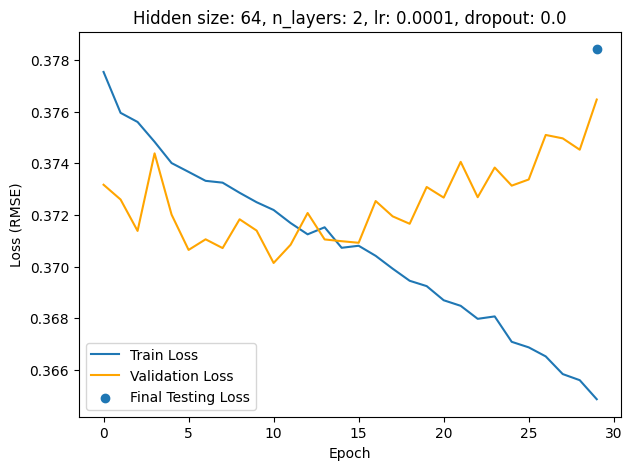

Hidden size: 64, n_layers: 2, lr: 0.0001, dropout: 0.25
Trainable parameters: 55,105


Training RNN: 100%|██████████| 30/30 [29:44<00:00, 59.47s/it, Train loss=0.372, Validation loss=0.37, Valid Running Slope=1.8e-5]    


Test RMSE: 0.3746, Test MAE: 0.2891


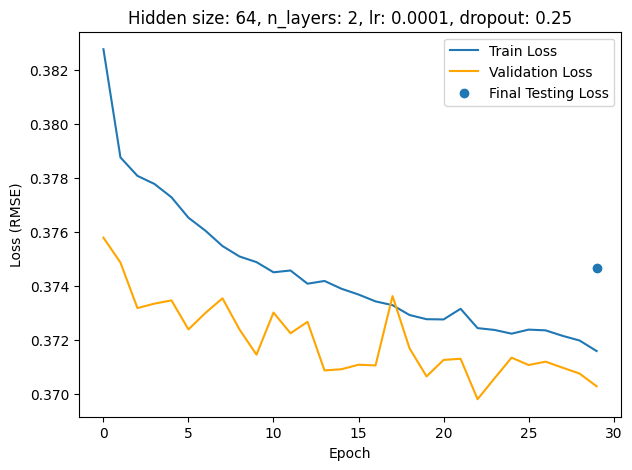

Hidden size: 64, n_layers: 2, lr: 0.0001, dropout: 0.33
Trainable parameters: 55,105


Training RNN: 100%|██████████| 30/30 [29:50<00:00, 59.68s/it, Train loss=0.372, Validation loss=0.37, Valid Running Slope=-7.57e-5]  


Test RMSE: 0.3737, Test MAE: 0.2870


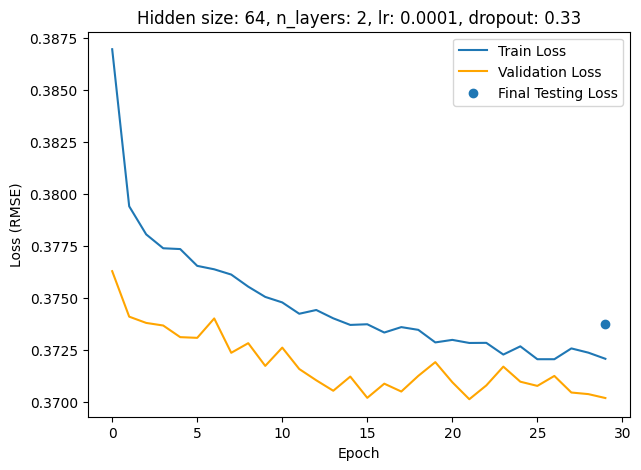

Hidden size: 64, n_layers: 2, lr: 0.0001, dropout: 0.5
Trainable parameters: 55,105


Training RNN: 100%|██████████| 30/30 [29:44<00:00, 59.50s/it, Train loss=0.373, Validation loss=0.371, Valid Running Slope=-6.94e-5] 


Test RMSE: 0.3745, Test MAE: 0.2888


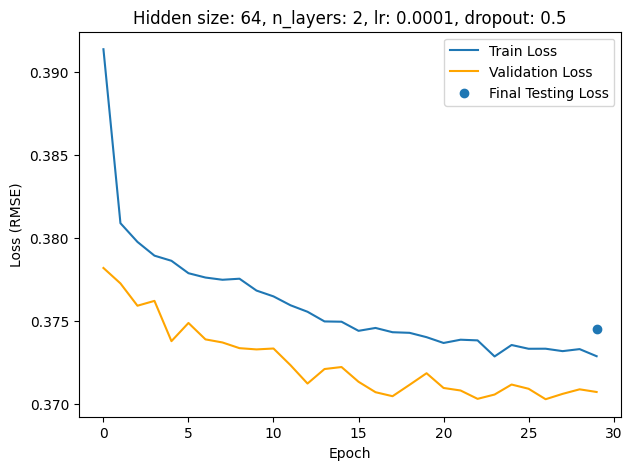

Hidden size: 128, n_layers: 1, lr: 0.001, dropout: 0.0
Trainable parameters: 117,633


Training RNN: 100%|██████████| 30/30 [17:17<00:00, 34.57s/it, Train loss=0.308, Validation loss=0.411, Valid Running Slope=0.00121] 


Test RMSE: 0.4123, Test MAE: 0.3091


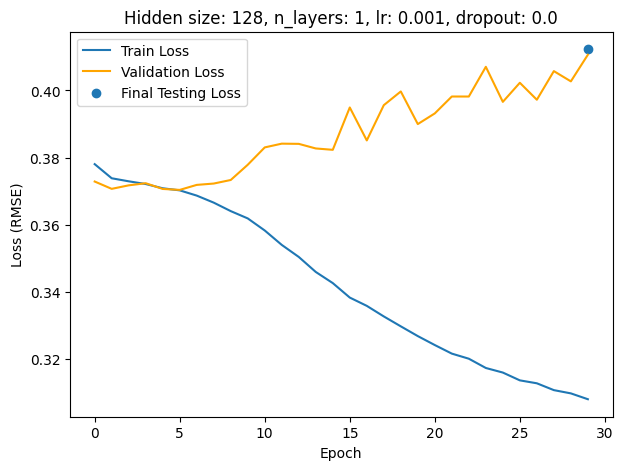

Hidden size: 128, n_layers: 1, lr: 0.001, dropout: 0.25
Trainable parameters: 117,633


Training RNN: 100%|██████████| 30/30 [18:12<00:00, 36.42s/it, Train loss=0.355, Validation loss=0.383, Valid Running Slope=-5.26e-5]


Test RMSE: 0.3859, Test MAE: 0.2985


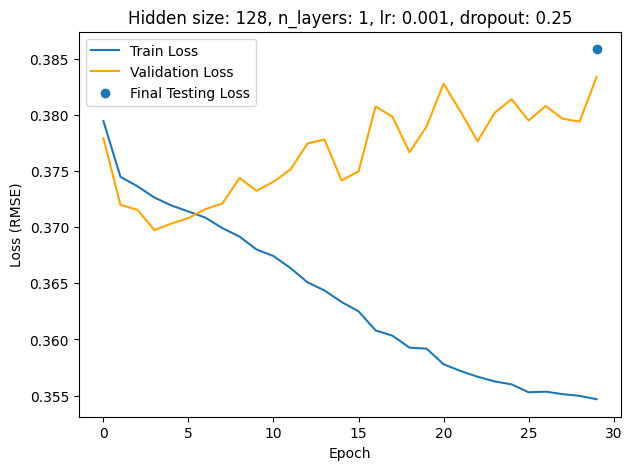

Hidden size: 128, n_layers: 1, lr: 0.001, dropout: 0.33
Trainable parameters: 117,633


Training RNN: 100%|██████████| 30/30 [18:15<00:00, 36.50s/it, Train loss=0.36, Validation loss=0.378, Valid Running Slope=0.00059]   


Test RMSE: 0.3813, Test MAE: 0.2929


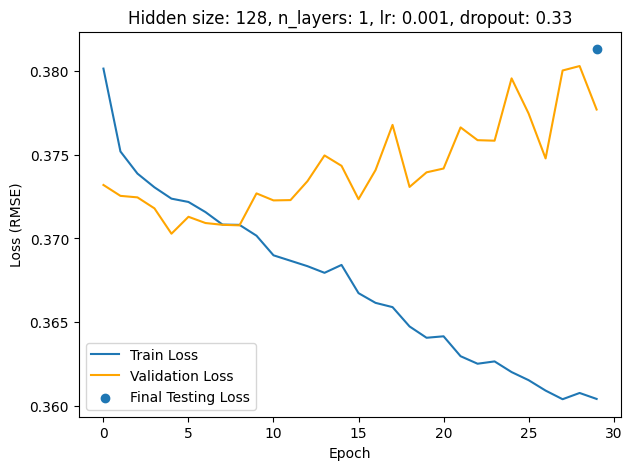

Hidden size: 128, n_layers: 1, lr: 0.001, dropout: 0.5
Trainable parameters: 117,633


Training RNN: 100%|██████████| 30/30 [18:06<00:00, 36.23s/it, Train loss=0.369, Validation loss=0.374, Valid Running Slope=-8.26e-6] 


Test RMSE: 0.3773, Test MAE: 0.2899


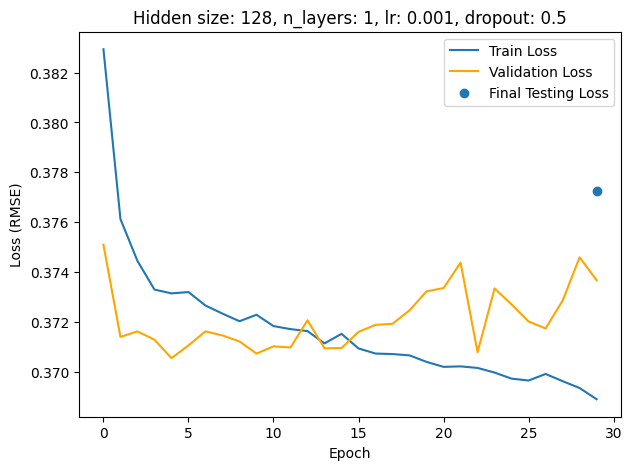

Hidden size: 128, n_layers: 1, lr: 0.0001, dropout: 0.0
Trainable parameters: 117,633


Training RNN: 100%|██████████| 30/30 [17:00<00:00, 34.02s/it, Train loss=0.351, Validation loss=0.385, Valid Running Slope=0.000877]


Test RMSE: 0.3872, Test MAE: 0.2973


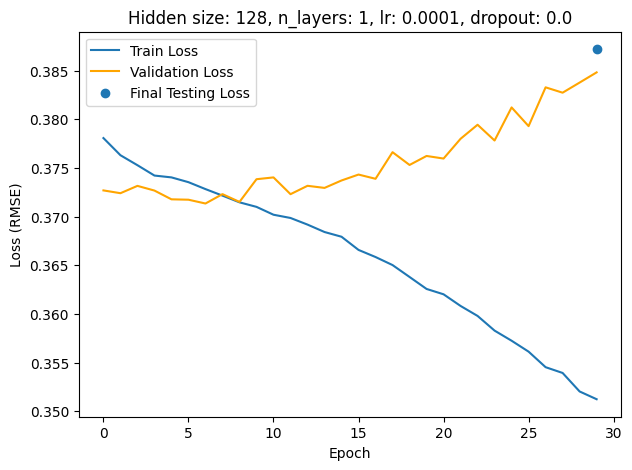

Hidden size: 128, n_layers: 1, lr: 0.0001, dropout: 0.25
Trainable parameters: 117,633


Training RNN: 100%|██████████| 30/30 [17:52<00:00, 35.74s/it, Train loss=0.367, Validation loss=0.375, Valid Running Slope=0.000285] 


Test RMSE: 0.3761, Test MAE: 0.2940


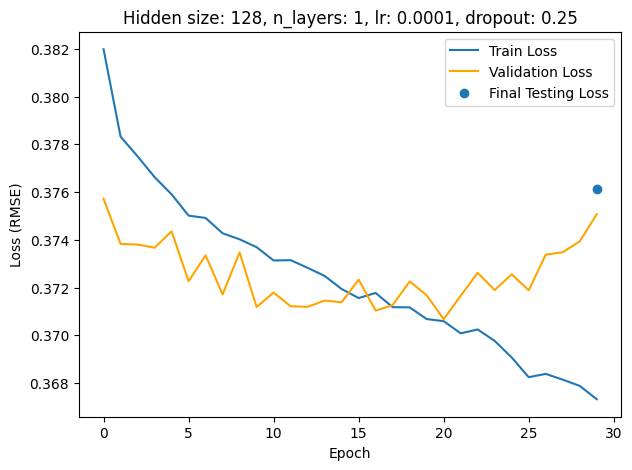

Hidden size: 128, n_layers: 1, lr: 0.0001, dropout: 0.33
Trainable parameters: 117,633


Training RNN: 100%|██████████| 30/30 [17:52<00:00, 35.76s/it, Train loss=0.37, Validation loss=0.372, Valid Running Slope=0.000349]  


Test RMSE: 0.3742, Test MAE: 0.2886


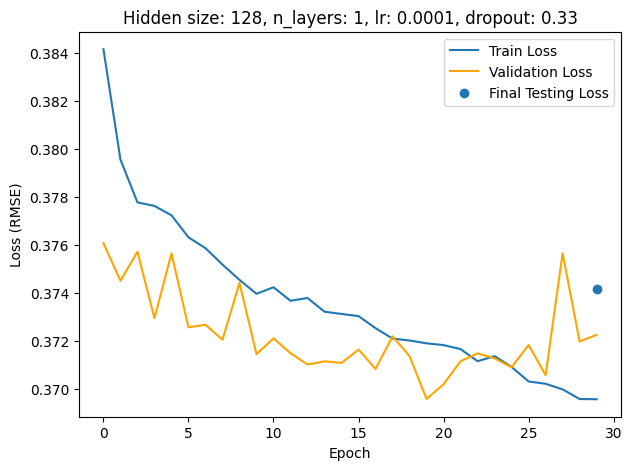

Hidden size: 128, n_layers: 1, lr: 0.0001, dropout: 0.5
Trainable parameters: 117,633


Training RNN: 100%|██████████| 30/30 [18:12<00:00, 36.43s/it, Train loss=0.371, Validation loss=0.371, Valid Running Slope=-4.6e-5]  


Test RMSE: 0.3743, Test MAE: 0.2893


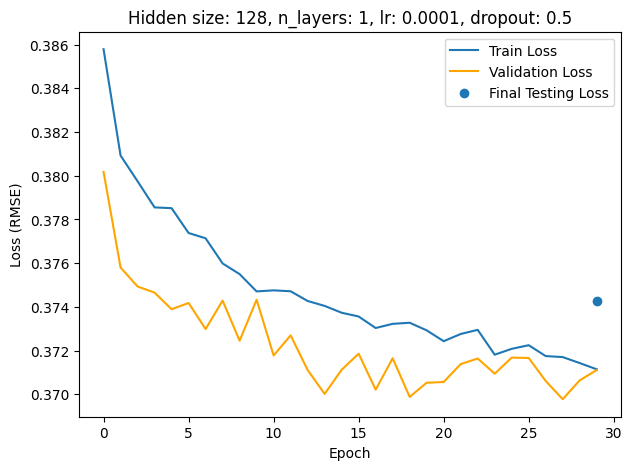

Hidden size: 128, n_layers: 2, lr: 0.001, dropout: 0.0
Trainable parameters: 216,705


Training RNN: 100%|██████████| 30/30 [29:38<00:00, 59.27s/it, Train loss=0.278, Validation loss=0.413, Valid Running Slope=0.00103]


Test RMSE: 0.4131, Test MAE: 0.3089


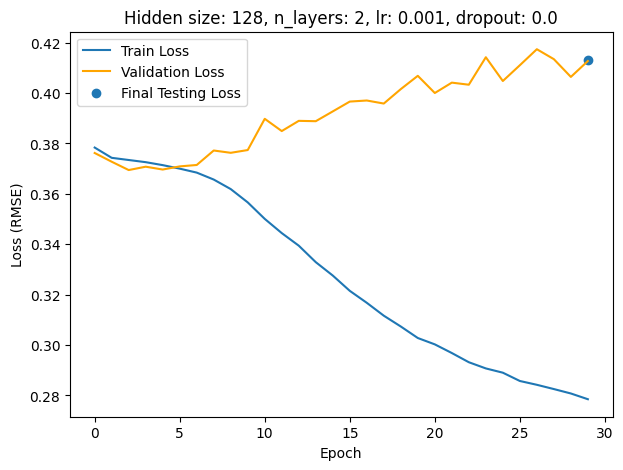

Hidden size: 128, n_layers: 2, lr: 0.001, dropout: 0.25
Trainable parameters: 216,705


Training RNN: 100%|██████████| 30/30 [31:23<00:00, 62.77s/it, Train loss=0.356, Validation loss=0.382, Valid Running Slope=0.000362]


Test RMSE: 0.3852, Test MAE: 0.2924


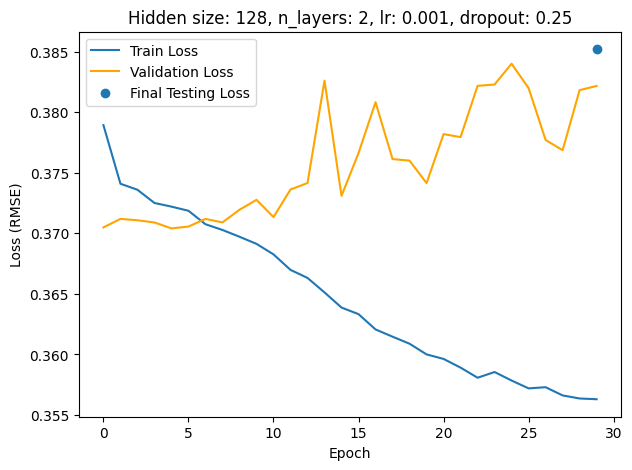

Hidden size: 128, n_layers: 2, lr: 0.001, dropout: 0.33
Trainable parameters: 216,705


Training RNN: 100%|██████████| 30/30 [30:41<00:00, 61.38s/it, Train loss=0.363, Validation loss=0.377, Valid Running Slope=3.9e-5]  


Test RMSE: 0.3799, Test MAE: 0.2938


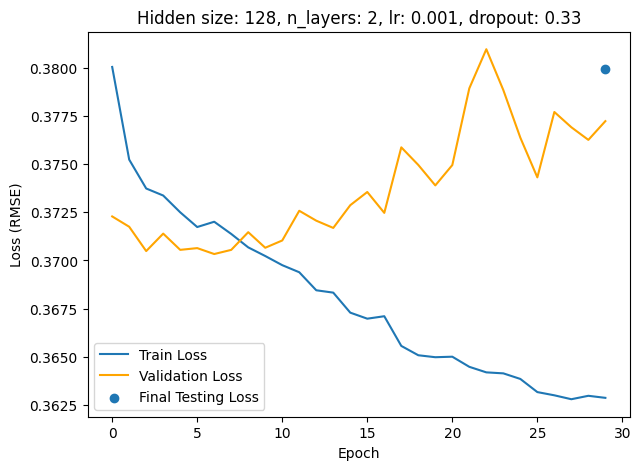

Hidden size: 128, n_layers: 2, lr: 0.001, dropout: 0.5
Trainable parameters: 216,705


Training RNN: 100%|██████████| 30/30 [30:15<00:00, 60.53s/it, Train loss=0.371, Validation loss=0.372, Valid Running Slope=0.000141] 


Test RMSE: 0.3753, Test MAE: 0.2899


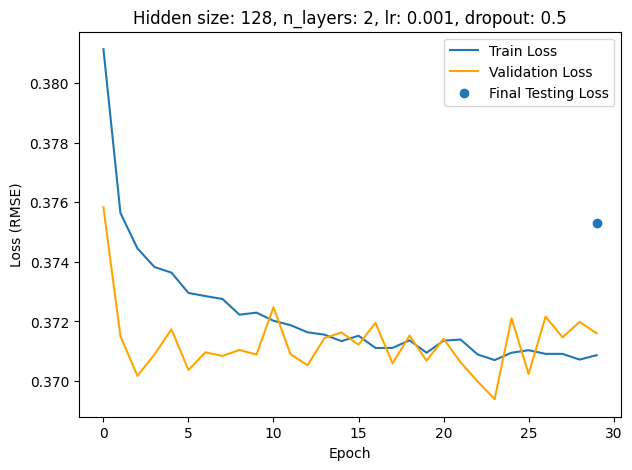

Hidden size: 128, n_layers: 2, lr: 0.0001, dropout: 0.0
Trainable parameters: 216,705


Training RNN: 100%|██████████| 30/30 [29:10<00:00, 58.34s/it, Train loss=0.343, Validation loss=0.391, Valid Running Slope=0.000933]


Test RMSE: 0.3947, Test MAE: 0.3005


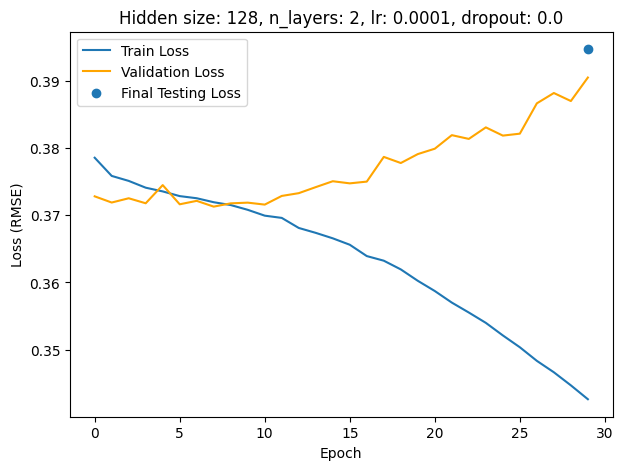

Hidden size: 128, n_layers: 2, lr: 0.0001, dropout: 0.25
Trainable parameters: 216,705


Training RNN: 100%|██████████| 30/30 [30:18<00:00, 60.63s/it, Train loss=0.366, Validation loss=0.373, Valid Running Slope=0.000167] 


Test RMSE: 0.3767, Test MAE: 0.2930


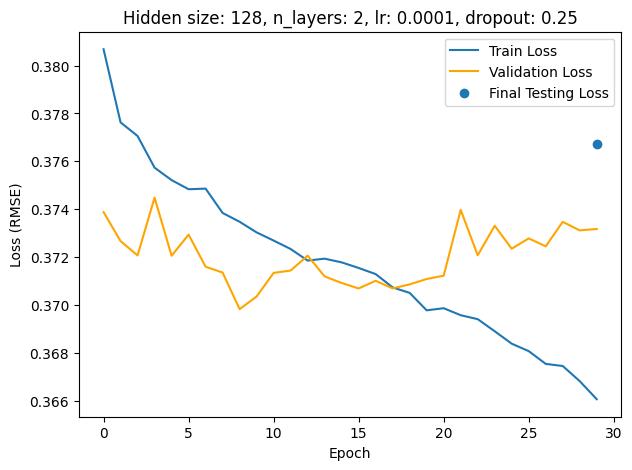

Hidden size: 128, n_layers: 2, lr: 0.0001, dropout: 0.33
Trainable parameters: 216,705


Training RNN: 100%|██████████| 30/30 [30:09<00:00, 60.33s/it, Train loss=0.369, Validation loss=0.372, Valid Running Slope=4.16e-5]  


Test RMSE: 0.3758, Test MAE: 0.2853


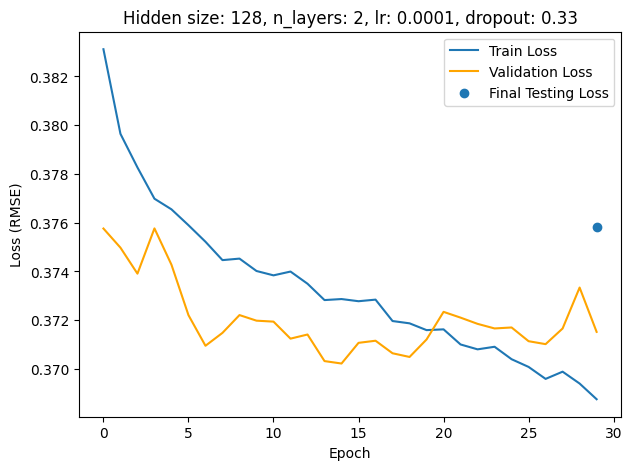

Hidden size: 128, n_layers: 2, lr: 0.0001, dropout: 0.5
Trainable parameters: 216,705


Training RNN: 100%|██████████| 30/30 [30:34<00:00, 61.15s/it, Train loss=0.371, Validation loss=0.373, Valid Running Slope=9.26e-5]  


Test RMSE: 0.3753, Test MAE: 0.2915


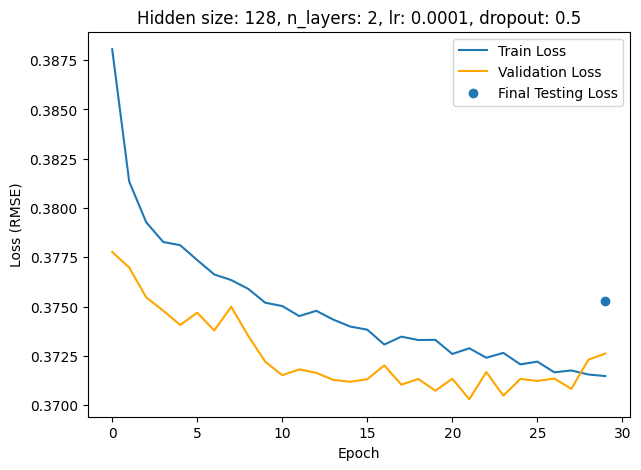

Hidden size: 256, n_layers: 1, lr: 0.001, dropout: 0.0
Trainable parameters: 464,641


Training RNN: 100%|██████████| 30/30 [17:59<00:00, 35.98s/it, Train loss=0.314, Validation loss=0.403, Valid Running Slope=0.000465]


Test RMSE: 0.4042, Test MAE: 0.3015


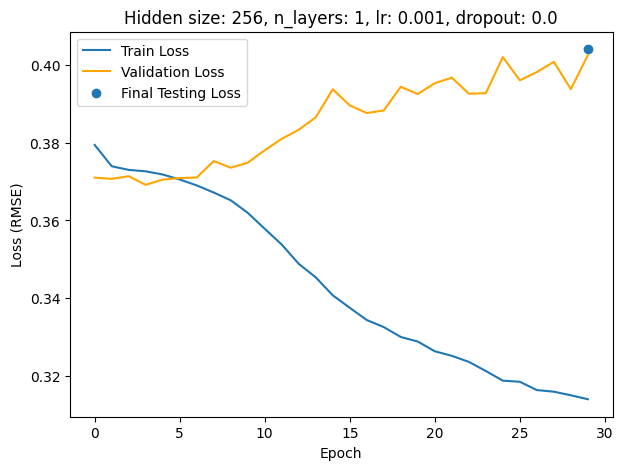

Hidden size: 256, n_layers: 1, lr: 0.001, dropout: 0.25
Trainable parameters: 464,641


Training RNN: 100%|██████████| 30/30 [18:54<00:00, 37.81s/it, Train loss=0.355, Validation loss=0.38, Valid Running Slope=-0.000281] 


Test RMSE: 0.3840, Test MAE: 0.2923


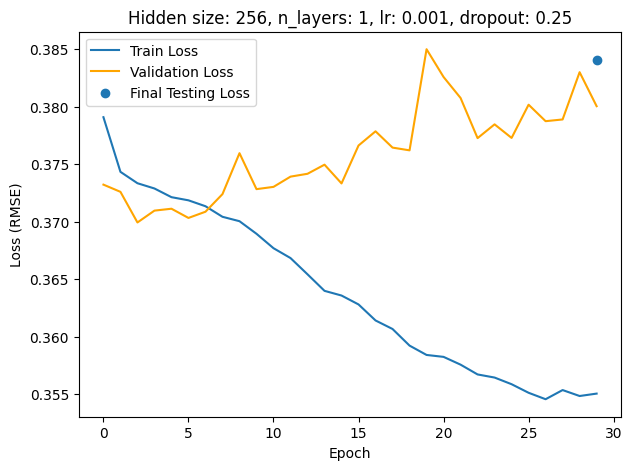

Hidden size: 256, n_layers: 1, lr: 0.001, dropout: 0.33
Trainable parameters: 464,641


Training RNN: 100%|██████████| 30/30 [19:01<00:00, 38.05s/it, Train loss=0.362, Validation loss=0.378, Valid Running Slope=-0.000137]


Test RMSE: 0.3794, Test MAE: 0.2898


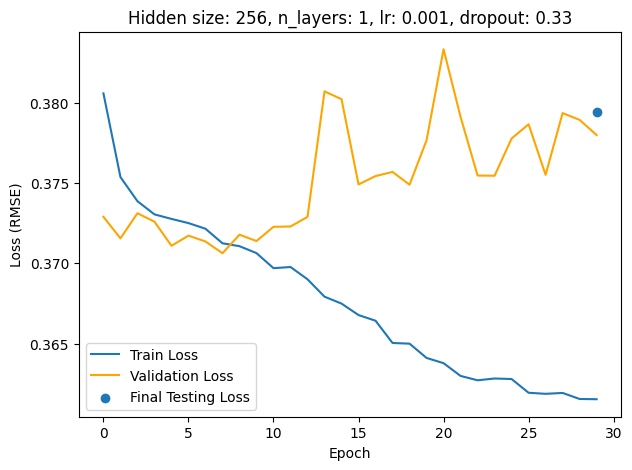

Hidden size: 256, n_layers: 1, lr: 0.001, dropout: 0.5
Trainable parameters: 464,641


Training RNN: 100%|██████████| 30/30 [18:51<00:00, 37.71s/it, Train loss=0.369, Validation loss=0.372, Valid Running Slope=0.000193] 


Test RMSE: 0.3764, Test MAE: 0.2870


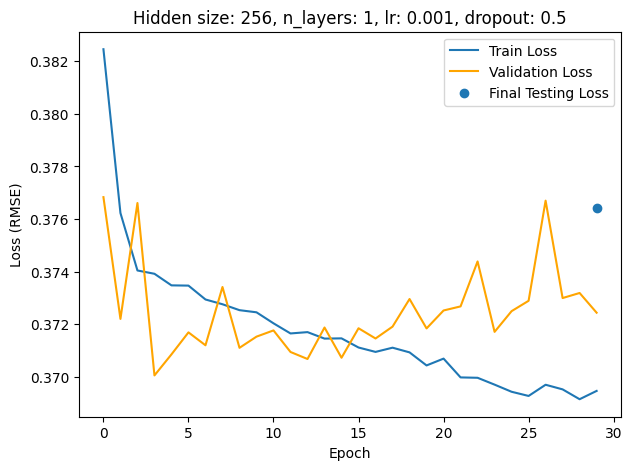

Hidden size: 256, n_layers: 1, lr: 0.0001, dropout: 0.0
Trainable parameters: 464,641


Training RNN: 100%|██████████| 30/30 [18:14<00:00, 36.47s/it, Train loss=0.304, Validation loss=0.408, Valid Running Slope=0.00224] 


Test RMSE: 0.4066, Test MAE: 0.3059


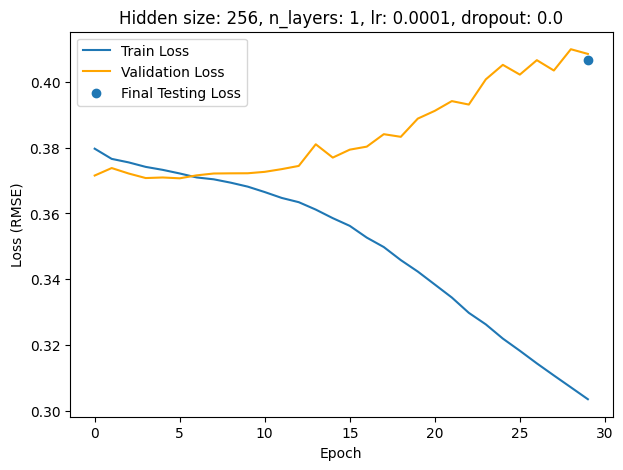

Hidden size: 256, n_layers: 1, lr: 0.0001, dropout: 0.25
Trainable parameters: 464,641


Training RNN: 100%|██████████| 30/30 [19:05<00:00, 38.19s/it, Train loss=0.343, Validation loss=0.384, Valid Running Slope=0.000971] 


Test RMSE: 0.3869, Test MAE: 0.2917


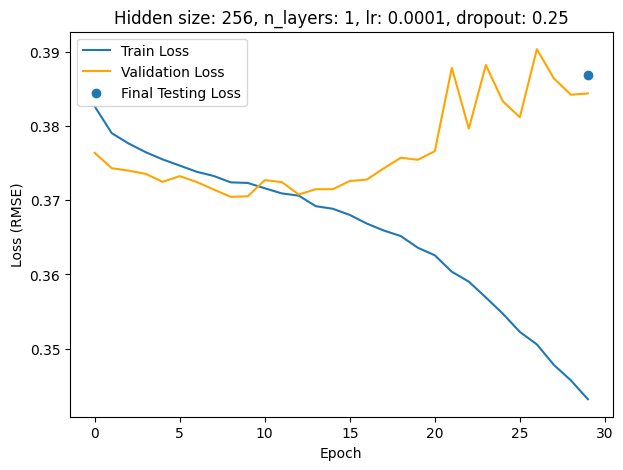

Hidden size: 256, n_layers: 1, lr: 0.0001, dropout: 0.33
Trainable parameters: 464,641


Training RNN: 100%|██████████| 30/30 [19:53<00:00, 39.77s/it, Train loss=0.351, Validation loss=0.387, Valid Running Slope=0.0015]   


Test RMSE: 0.3891, Test MAE: 0.2980


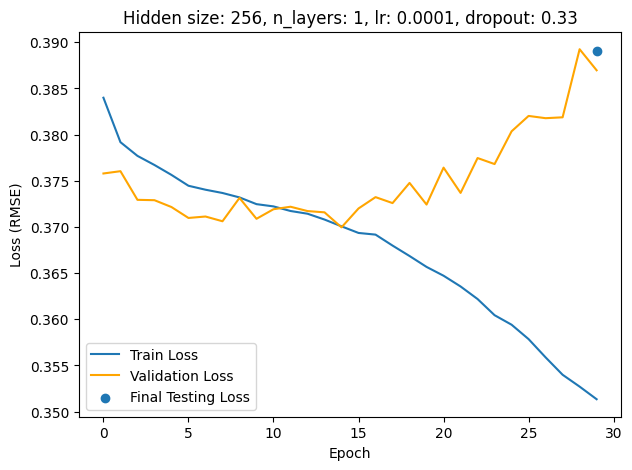

Hidden size: 256, n_layers: 1, lr: 0.0001, dropout: 0.5
Trainable parameters: 464,641


Training RNN: 100%|██████████| 30/30 [20:17<00:00, 40.59s/it, Train loss=0.363, Validation loss=0.377, Valid Running Slope=0.000456] 


Test RMSE: 0.3805, Test MAE: 0.2897


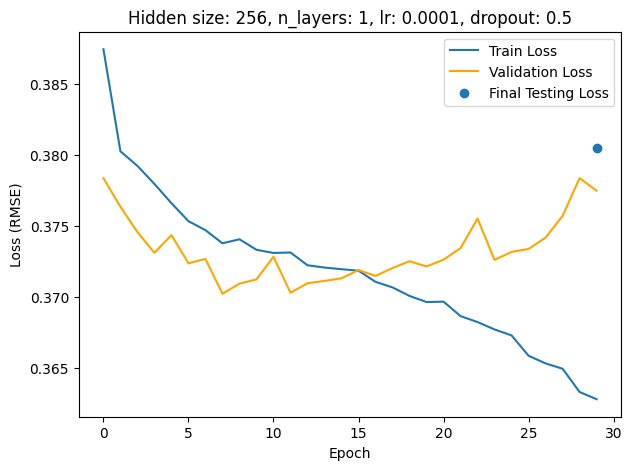

Hidden size: 256, n_layers: 2, lr: 0.001, dropout: 0.0
Trainable parameters: 859,393


Training RNN: 100%|██████████| 30/30 [33:13<00:00, 66.45s/it, Train loss=0.301, Validation loss=0.414, Valid Running Slope=0.00077]


Test RMSE: 0.4130, Test MAE: 0.3151


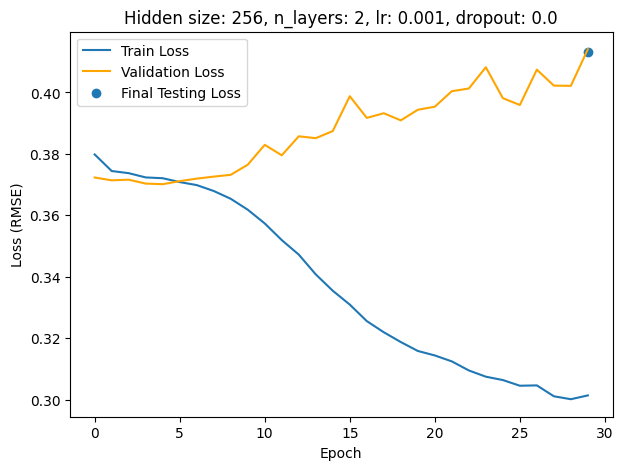

Hidden size: 256, n_layers: 2, lr: 0.001, dropout: 0.25
Trainable parameters: 859,393


Training RNN: 100%|██████████| 30/30 [33:47<00:00, 67.57s/it, Train loss=0.362, Validation loss=0.375, Valid Running Slope=0.000131]


Test RMSE: 0.3801, Test MAE: 0.2897


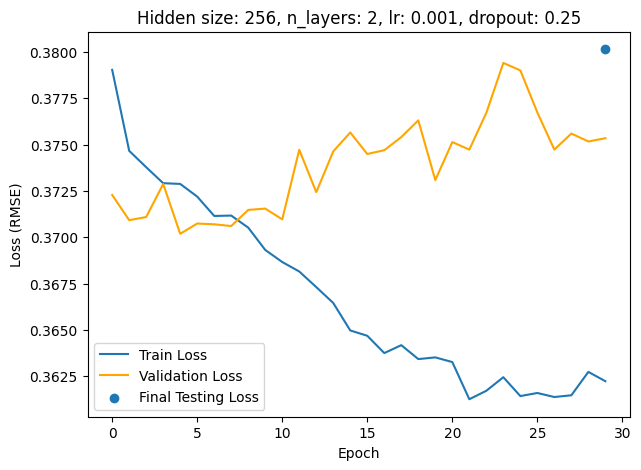

Hidden size: 256, n_layers: 2, lr: 0.001, dropout: 0.33
Trainable parameters: 859,393


Training RNN: 100%|██████████| 30/30 [33:55<00:00, 67.86s/it, Train loss=0.366, Validation loss=0.376, Valid Running Slope=0.000171]


Test RMSE: 0.3804, Test MAE: 0.2925


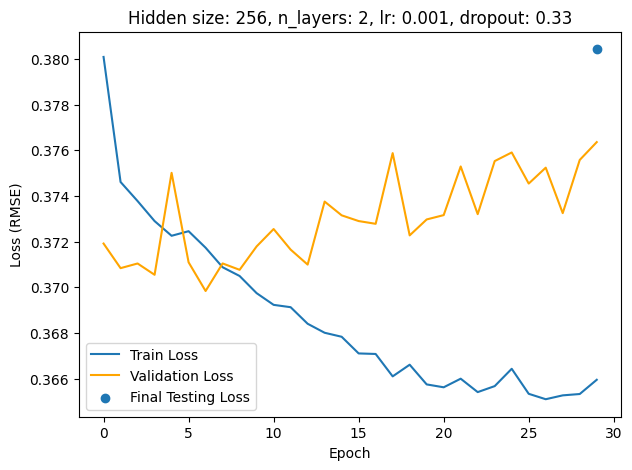

Hidden size: 256, n_layers: 2, lr: 0.001, dropout: 0.5
Trainable parameters: 859,393


Training RNN: 100%|██████████| 30/30 [33:54<00:00, 67.81s/it, Train loss=0.371, Validation loss=0.372, Valid Running Slope=7.66e-5]  


Test RMSE: 0.3750, Test MAE: 0.2862


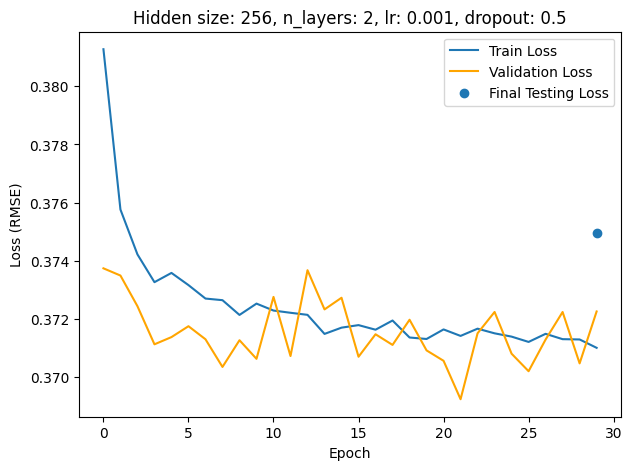

Hidden size: 256, n_layers: 2, lr: 0.0001, dropout: 0.0
Trainable parameters: 859,393


Training RNN: 100%|██████████| 30/30 [32:18<00:00, 64.62s/it, Train loss=0.282, Validation loss=0.423, Valid Running Slope=0.00155]  


Test RMSE: 0.4202, Test MAE: 0.3148


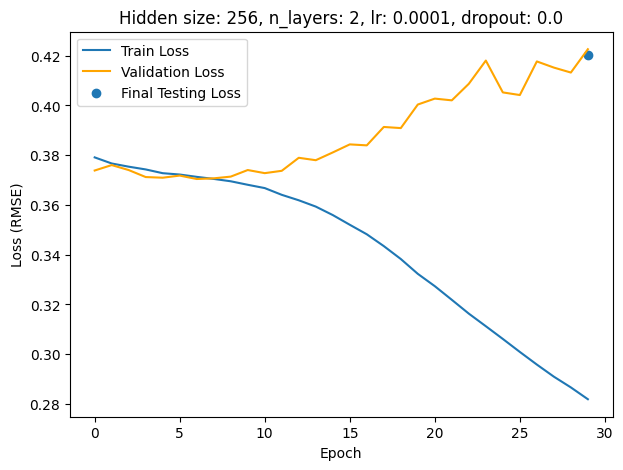

Hidden size: 256, n_layers: 2, lr: 0.0001, dropout: 0.25
Trainable parameters: 859,393


Training RNN: 100%|██████████| 30/30 [33:38<00:00, 67.29s/it, Train loss=0.339, Validation loss=0.383, Valid Running Slope=0.00196]  


Test RMSE: 0.3850, Test MAE: 0.2950


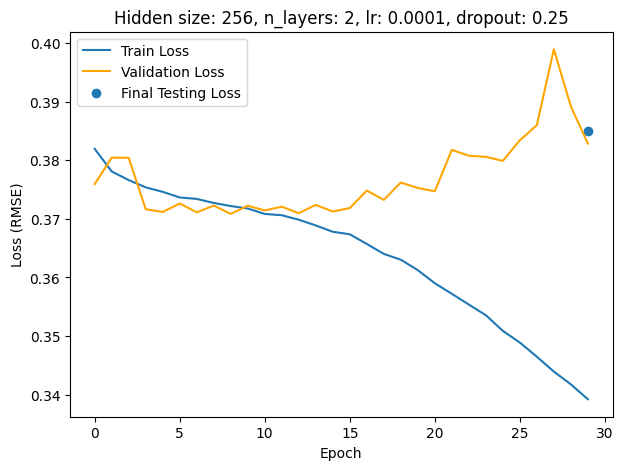

Hidden size: 256, n_layers: 2, lr: 0.0001, dropout: 0.33
Trainable parameters: 859,393


Training RNN: 100%|██████████| 30/30 [33:45<00:00, 67.51s/it, Train loss=0.347, Validation loss=0.384, Valid Running Slope=0.00136]  


Test RMSE: 0.3844, Test MAE: 0.2941


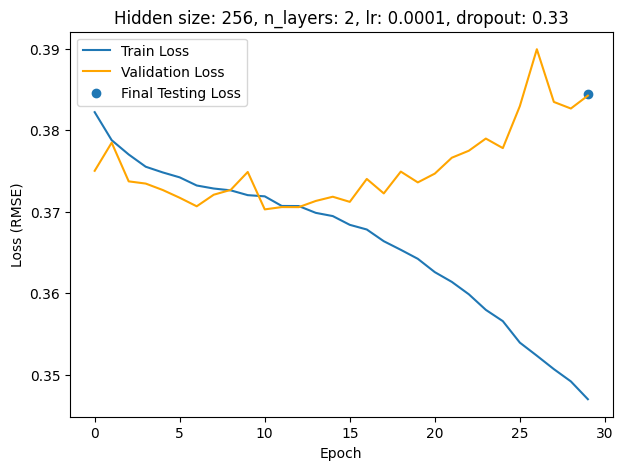

Hidden size: 256, n_layers: 2, lr: 0.0001, dropout: 0.5
Trainable parameters: 859,393


Training RNN: 100%|██████████| 30/30 [33:43<00:00, 67.43s/it, Train loss=0.362, Validation loss=0.375, Valid Running Slope=0.000252] 


Test RMSE: 0.3788, Test MAE: 0.2881


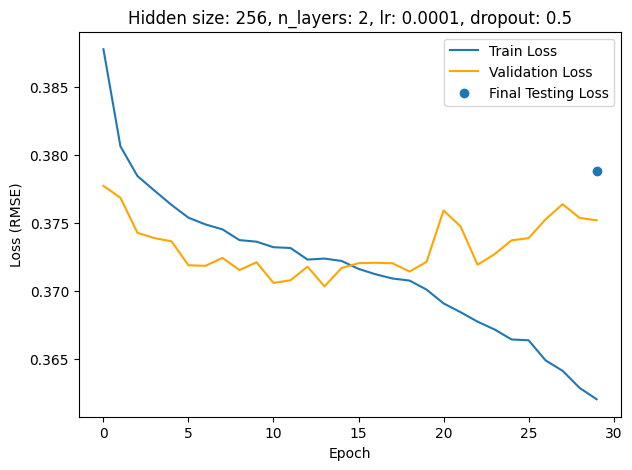

In [380]:
# Initialize the model and move it to the appropriate device
for hidden_size in hyperparameters['hidden_size']:
    for n_layers in hyperparameters['n_layers']:
        for learning_rate in hyperparameters['learning_rate']:
            for rnn_dropout in hyperparameters['rnn_dropout']:

                print(f'Hidden size: {hidden_size}, n_layers: {n_layers}, lr: {learning_rate}, dropout: {rnn_dropout}')

                rnn_type = 'GRU'
                lr = learning_rate
                input_size = train_dataloader.dataset[0][0].size()[1]
                RNN_model = BaseballRNN_test(input_size=input_size, output_size=1, hidden_size=hidden_size,
                                            fc_hidden_size=hidden_size, n_layers=n_layers, rnn_type=rnn_type,
                                            hidden_init='zero', rnn_dropout=rnn_dropout).to(DEVICE)

                # Print trainable parameters
                trainable_params = sum(p.numel() for p in RNN_model.parameters() if p.requires_grad)
                print(f"Trainable parameters: {trainable_params:,}")

                # Define the loss function and optimizer
                optimizer = torch.optim.Adam(RNN_model.parameters(), lr=lr)

                # Training loop
                num_epochs = 30
                log = []
                eval_log = []


                # Training loop
                pbar = tqdm(range(num_epochs), desc="Training RNN")
                for epoch in pbar:

                    # Get average loss over batches for training
                    avg_train_loss = train_model(RNN_model, optimizer, train_dataloader, DEVICE)
                    log.append(avg_train_loss)
                    avg_valid_loss = evaluate_model_RSME(RNN_model, valid_dataloader, DEVICE)
                    eval_log.append(avg_valid_loss)

                    if epoch > 9:
                        valid_running_slope, _ = np.polyfit(np.arange(1, 11, 1), eval_log[epoch-10:epoch], 1)
                    else: valid_running_slope = np.nan
                    # Print loss every 5 epochs
                    #if epoch % 5 == 0:
                    #print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")

                    pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss, 'Valid Running Slope': valid_running_slope})


                # Final output
                #print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")
                test_accuracy_RSME = evaluate_model_RSME(RNN_model, test_dataloader, DEVICE)
                test_accuracy_MAE = evaluate_model_MAE(RNN_model, test_dataloader, DEVICE)

                print(f'Test RMSE: {test_accuracy_RSME:.4f}, Test MAE: {test_accuracy_MAE:.4f}')


                # Plot loss over time
                plt.figure(figsize=(7, 5))
                plt.title(f'Hidden size: {hidden_size}, n_layers: {n_layers}, lr: {learning_rate}, dropout: {rnn_dropout}')
                plt.ylabel('Loss (RMSE)')
                plt.xlabel('Epoch')
                plt.plot(log, label='Train Loss')
                plt.plot(eval_log, label='Validation Loss', color='orange')
                plt.scatter(x=epoch, y=test_accuracy_RSME, label='Final Testing Loss')
                plt.legend()

                plt.show()

Further testing hyperparameters - fine tuning. Adding new learning rate and testing for 40 instead of 30 epochs.

/Users/zacharyarmand/Desktop/DS-5500/.venv/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.33 and num_layers=1
  warnings.warn(


Hidden size: 64, n_layers: 1, lr: 0.0001, dropout: 0.33
Trainable parameters: 30,145


Training RNN: 100%|██████████| 40/40 [25:31<00:00, 38.29s/it, Train loss=0.371, Validation loss=0.371, Valid Running Slope=2.2e-5]   


Test RMSE: 0.3751, Test MAE: 0.2949


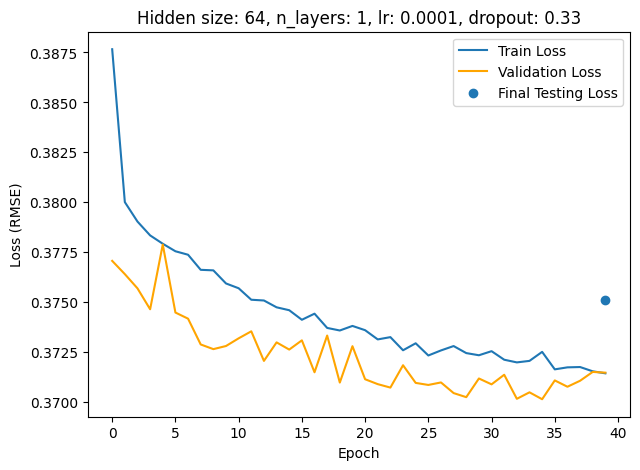

/Users/zacharyarmand/Desktop/DS-5500/.venv/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Hidden size: 64, n_layers: 1, lr: 0.0001, dropout: 0.5
Trainable parameters: 30,145


Training RNN: 100%|██████████| 40/40 [25:29<00:00, 38.23s/it, Train loss=0.373, Validation loss=0.37, Valid Running Slope=-7.15e-5]  


Test RMSE: 0.3750, Test MAE: 0.2871


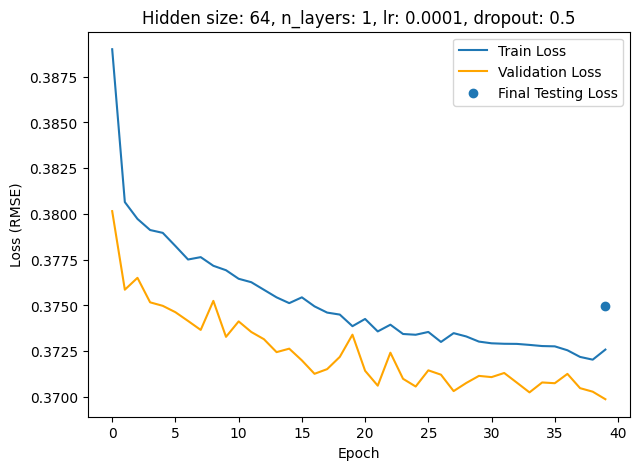

Hidden size: 64, n_layers: 1, lr: 1e-05, dropout: 0.33
Trainable parameters: 30,145


Training RNN: 100%|██████████| 40/40 [25:19<00:00, 37.98s/it, Train loss=0.377, Validation loss=0.374, Valid Running Slope=-0.000103]


Test RMSE: 0.3771, Test MAE: 0.2916


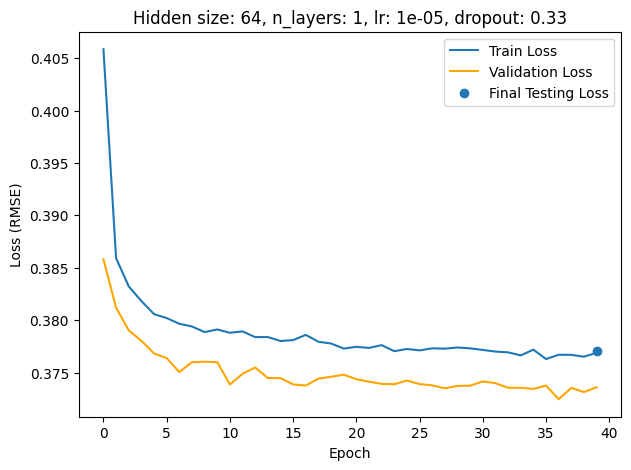

Hidden size: 64, n_layers: 1, lr: 1e-05, dropout: 0.5
Trainable parameters: 30,145


Training RNN: 100%|██████████| 40/40 [25:14<00:00, 37.87s/it, Train loss=0.378, Validation loss=0.375, Valid Running Slope=-0.00011] 


Test RMSE: 0.3796, Test MAE: 0.2929


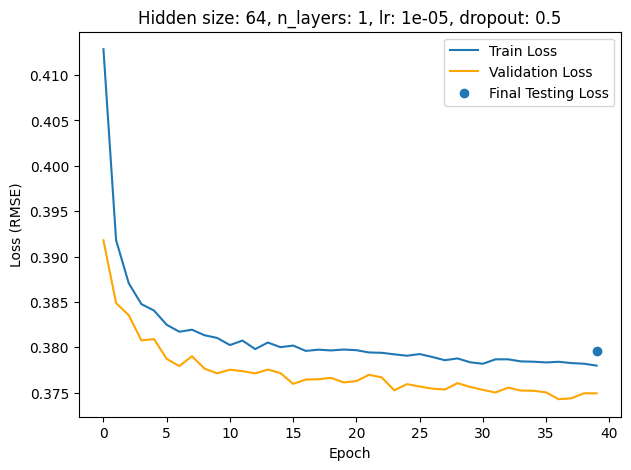

Hidden size: 64, n_layers: 2, lr: 0.0001, dropout: 0.33
Trainable parameters: 55,105


Training RNN: 100%|██████████| 40/40 [42:47<00:00, 64.19s/it, Train loss=0.371, Validation loss=0.372, Valid Running Slope=4.85e-6]  


Test RMSE: 0.3740, Test MAE: 0.2888


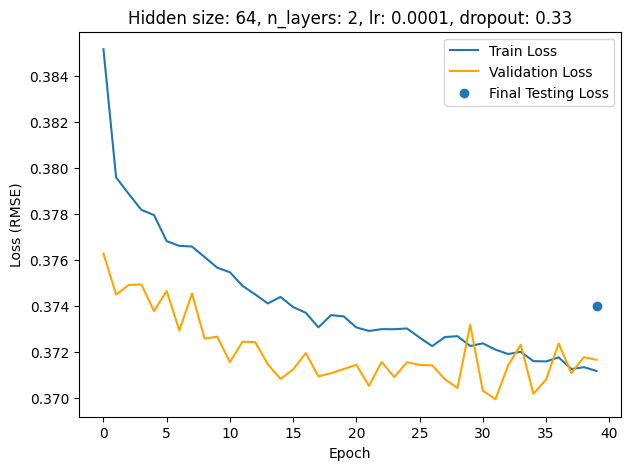

Hidden size: 64, n_layers: 2, lr: 0.0001, dropout: 0.5
Trainable parameters: 55,105


Training RNN: 100%|██████████| 40/40 [42:19<00:00, 63.49s/it, Train loss=0.372, Validation loss=0.372, Valid Running Slope=-6.63e-5] 


Test RMSE: 0.3745, Test MAE: 0.2846


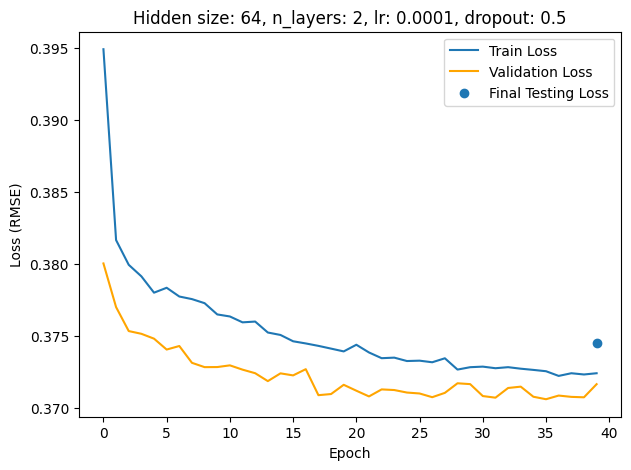

Hidden size: 64, n_layers: 2, lr: 1e-05, dropout: 0.33
Trainable parameters: 55,105


Training RNN: 100%|██████████| 40/40 [42:33<00:00, 63.85s/it, Train loss=0.377, Validation loss=0.373, Valid Running Slope=-4.29e-5] 


Test RMSE: 0.3766, Test MAE: 0.2909


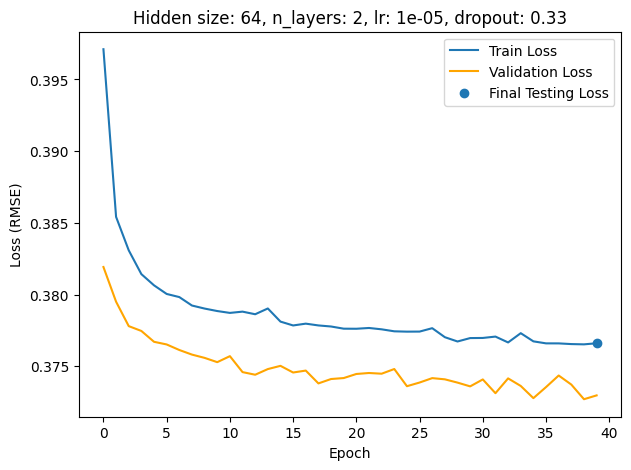

Hidden size: 64, n_layers: 2, lr: 1e-05, dropout: 0.5
Trainable parameters: 55,105


Training RNN: 100%|██████████| 40/40 [42:19<00:00, 63.48s/it, Train loss=0.378, Validation loss=0.374, Valid Running Slope=-1.43e-5] 


Test RMSE: 0.3776, Test MAE: 0.2933


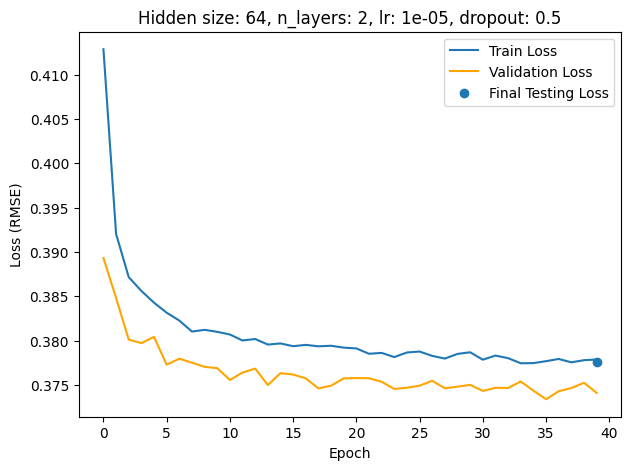

Hidden size: 128, n_layers: 1, lr: 0.0001, dropout: 0.33
Trainable parameters: 117,633


Training RNN: 100%|██████████| 40/40 [25:34<00:00, 38.36s/it, Train loss=0.366, Validation loss=0.374, Valid Running Slope=0.000213] 


Test RMSE: 0.3775, Test MAE: 0.2888


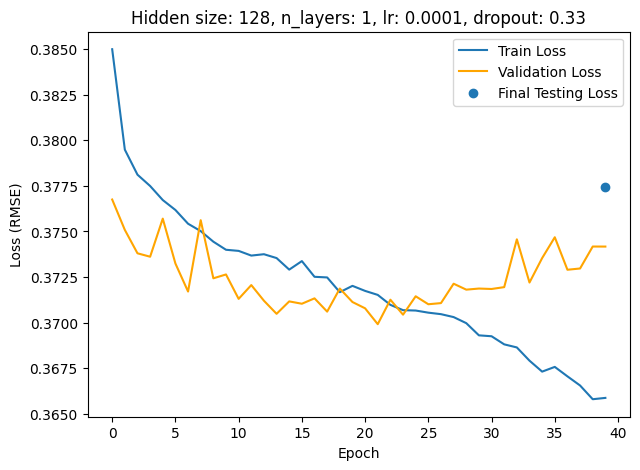

Hidden size: 128, n_layers: 1, lr: 0.0001, dropout: 0.5
Trainable parameters: 117,633


Training RNN: 100%|██████████| 40/40 [25:32<00:00, 38.31s/it, Train loss=0.37, Validation loss=0.374, Valid Running Slope=7.43e-5]   


Test RMSE: 0.3764, Test MAE: 0.2902


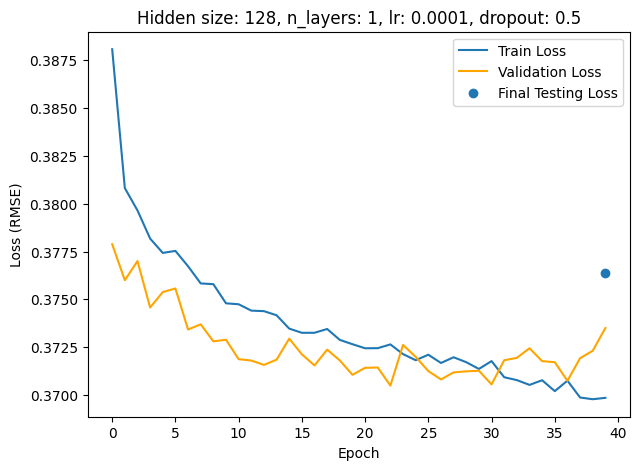

Hidden size: 128, n_layers: 1, lr: 1e-05, dropout: 0.33
Trainable parameters: 117,633


Training RNN: 100%|██████████| 40/40 [25:42<00:00, 38.56s/it, Train loss=0.376, Validation loss=0.374, Valid Running Slope=-2.36e-5] 


Test RMSE: 0.3756, Test MAE: 0.2925


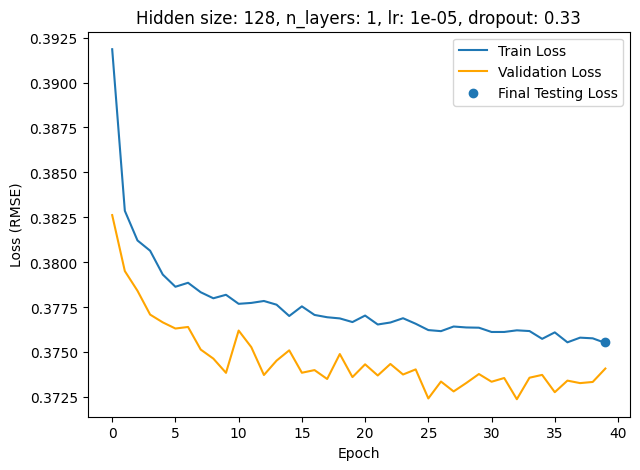

Hidden size: 128, n_layers: 1, lr: 1e-05, dropout: 0.5
Trainable parameters: 117,633


Training RNN: 100%|██████████| 40/40 [25:24<00:00, 38.10s/it, Train loss=0.377, Validation loss=0.374, Valid Running Slope=-0.000111]


Test RMSE: 0.3783, Test MAE: 0.2916


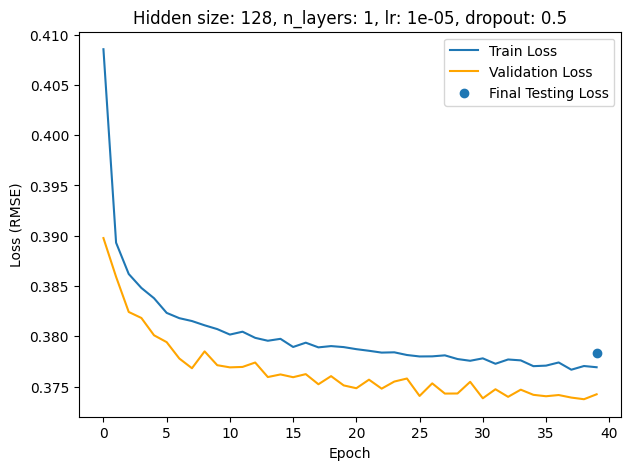

Hidden size: 128, n_layers: 2, lr: 0.0001, dropout: 0.33
Trainable parameters: 216,705


Training RNN: 100%|██████████| 40/40 [43:28<00:00, 65.20s/it, Train loss=0.365, Validation loss=0.377, Valid Running Slope=0.000208] 


Test RMSE: 0.3786, Test MAE: 0.2895


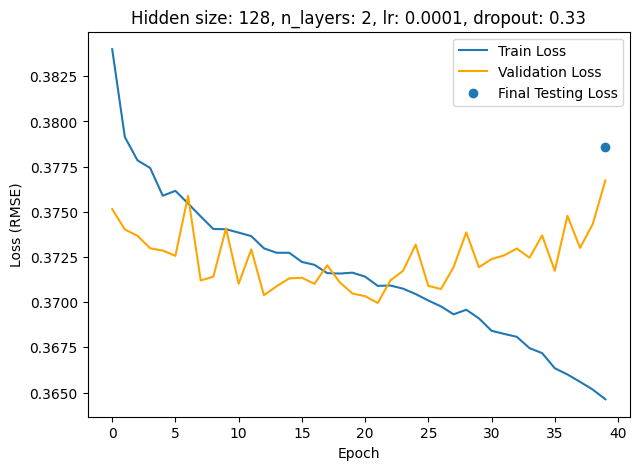

Hidden size: 128, n_layers: 2, lr: 0.0001, dropout: 0.5
Trainable parameters: 216,705


Training RNN: 100%|██████████| 40/40 [43:27<00:00, 65.18s/it, Train loss=0.369, Validation loss=0.372, Valid Running Slope=8.98e-5]  


Test RMSE: 0.3744, Test MAE: 0.2908


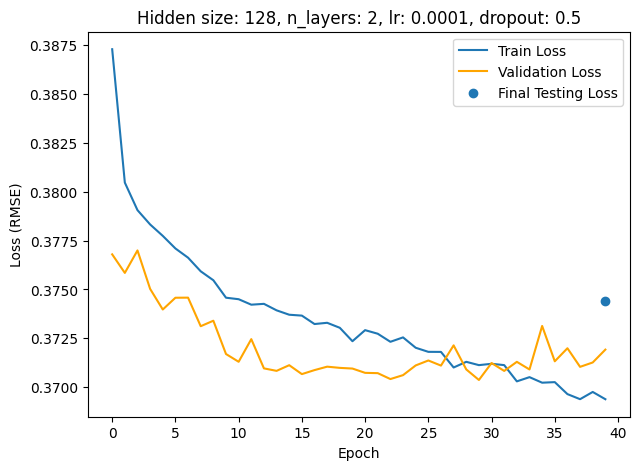

Hidden size: 128, n_layers: 2, lr: 1e-05, dropout: 0.33
Trainable parameters: 216,705


Training RNN: 100%|██████████| 40/40 [43:20<00:00, 65.01s/it, Train loss=0.376, Validation loss=0.373, Valid Running Slope=-6.26e-5] 


Test RMSE: 0.3762, Test MAE: 0.2902


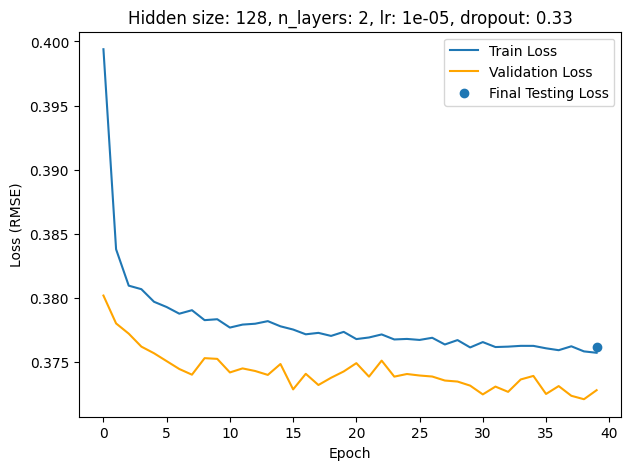

Hidden size: 128, n_layers: 2, lr: 1e-05, dropout: 0.5
Trainable parameters: 216,705


Training RNN: 100%|██████████| 40/40 [43:23<00:00, 65.09s/it, Train loss=0.377, Validation loss=0.373, Valid Running Slope=-9.71e-5] 


Test RMSE: 0.3772, Test MAE: 0.2904


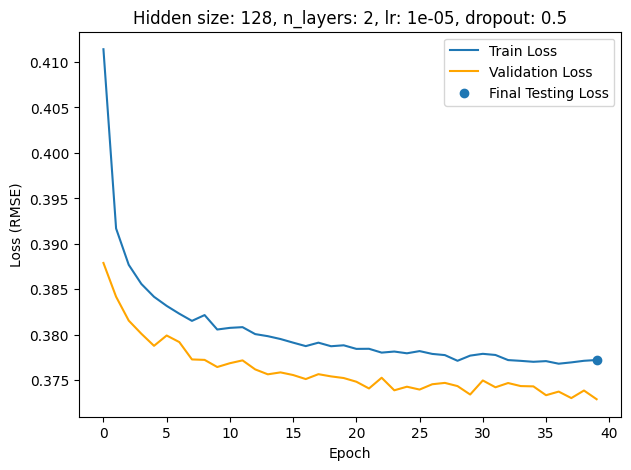

In [399]:
# Initialize the model and move it to the appropriate device
for hidden_size in [64, 128]:
    for n_layers in [1, 2]:
        for learning_rate in [0.0001, 0.00001]:
            for rnn_dropout in [0.33, 0.5]:

                print(f'Hidden size: {hidden_size}, n_layers: {n_layers}, lr: {learning_rate}, dropout: {rnn_dropout}')

                rnn_type = 'GRU'
                lr = learning_rate
                input_size = train_dataloader.dataset[0][0].size()[1]
                RNN_model = BaseballRNN_test(input_size=input_size, output_size=1, hidden_size=hidden_size,
                                            fc_hidden_size=hidden_size, n_layers=n_layers, rnn_type=rnn_type,
                                            hidden_init='zero', rnn_dropout=rnn_dropout).to(DEVICE)

                # Print trainable parameters
                trainable_params = sum(p.numel() for p in RNN_model.parameters() if p.requires_grad)
                print(f"Trainable parameters: {trainable_params:,}")

                # Define the loss function and optimizer
                optimizer = torch.optim.Adam(RNN_model.parameters(), lr=lr)

                # Training loop
                num_epochs = 40
                log = []
                eval_log = []


                # Training loop
                pbar = tqdm(range(num_epochs), desc="Training RNN")
                for epoch in pbar:

                    # Get average loss over batches for training
                    avg_train_loss = train_model(RNN_model, optimizer, train_dataloader, DEVICE)
                    log.append(avg_train_loss)
                    avg_valid_loss = evaluate_model_RSME(RNN_model, valid_dataloader, DEVICE)
                    eval_log.append(avg_valid_loss)

                    if epoch > 9:
                        valid_running_slope, _ = np.polyfit(np.arange(1, 11, 1), eval_log[epoch-10:epoch], 1)
                    else: valid_running_slope = np.nan
                    # Print loss every 5 epochs
                    #if epoch % 5 == 0:
                    #print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")

                    pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss, 'Valid Running Slope': valid_running_slope})


                # Final output
                #print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")
                test_accuracy_RSME = evaluate_model_RSME(RNN_model, test_dataloader, DEVICE)
                test_accuracy_MAE = evaluate_model_MAE(RNN_model, test_dataloader, DEVICE)

                print(f'Test RMSE: {test_accuracy_RSME:.4f}, Test MAE: {test_accuracy_MAE:.4f}')


                # Plot loss over time
                plt.figure(figsize=(7, 5))
                plt.title(f'Hidden size: {hidden_size}, n_layers: {n_layers}, lr: {learning_rate}, dropout: {rnn_dropout}')
                plt.ylabel('Loss (RMSE)')
                plt.xlabel('Epoch')
                plt.plot(log, label='Train Loss')
                plt.plot(eval_log, label='Validation Loss', color='orange')
                plt.scatter(x=epoch, y=test_accuracy_RSME, label='Final Testing Loss')
                plt.legend()

                plt.show()

One final round of fine tuning

Hidden size: 64, n_layers: 1, lr: 0.0001, dropout: 0.5
Trainable parameters: 30,145


Training RNN: 100%|██████████| 60/60 [37:56<00:00, 37.93s/it, Train loss=0.371, Validation loss=0.371, Valid Running Slope=7.14e-5]  


Test RMSE: 0.3734, Test MAE: 0.2877


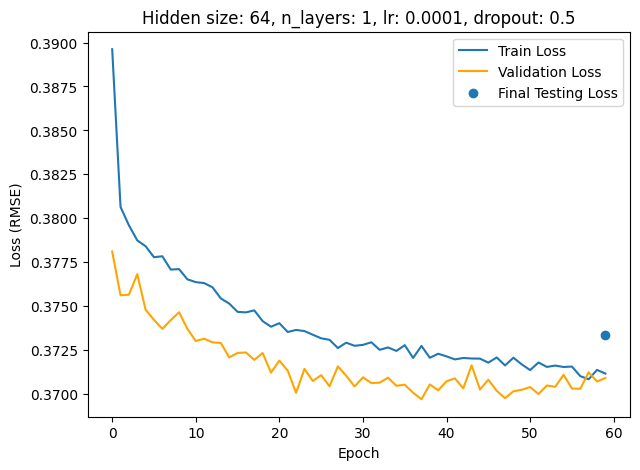

Hidden size: 64, n_layers: 2, lr: 0.0001, dropout: 0.5
Trainable parameters: 55,105


Training RNN: 100%|██████████| 60/60 [1:04:00<00:00, 64.00s/it, Train loss=0.371, Validation loss=0.37, Valid Running Slope=2.63e-5]  


Test RMSE: 0.3737, Test MAE: 0.2885


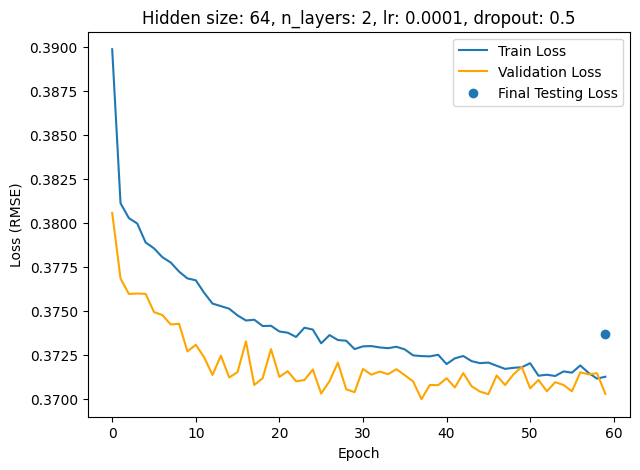

Hidden size: 128, n_layers: 1, lr: 0.0001, dropout: 0.5
Trainable parameters: 117,633


Training RNN: 100%|██████████| 60/60 [38:44<00:00, 38.74s/it, Train loss=0.364, Validation loss=0.374, Valid Running Slope=0.00011]  


Test RMSE: 0.3769, Test MAE: 0.2878


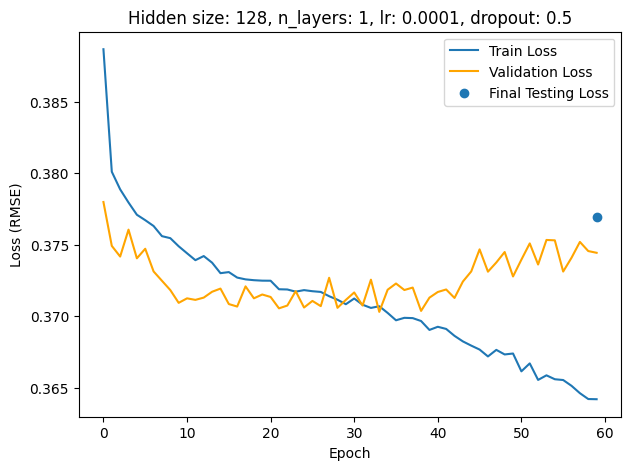

Hidden size: 128, n_layers: 2, lr: 0.0001, dropout: 0.5
Trainable parameters: 216,705


Training RNN: 100%|██████████| 60/60 [1:51:08<00:00, 111.14s/it, Train loss=0.364, Validation loss=0.374, Valid Running Slope=-2.15e-5]   


Test RMSE: 0.3778, Test MAE: 0.2901


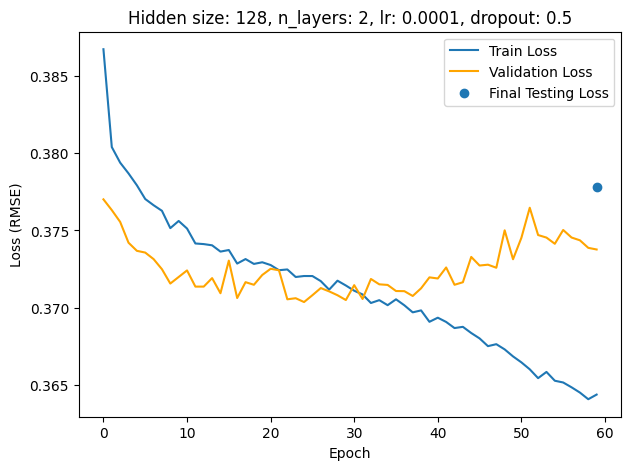

In [400]:
# Initialize the model and move it to the appropriate device
for hidden_size in [64, 128]:
    for n_layers in [1, 2]:
        for learning_rate in [0.0001]:
            for rnn_dropout in [0.5]:

                print(f'Hidden size: {hidden_size}, n_layers: {n_layers}, lr: {learning_rate}, dropout: {rnn_dropout}')

                rnn_type = 'GRU'
                lr = learning_rate
                input_size = train_dataloader.dataset[0][0].size()[1]
                RNN_model = BaseballRNN_test(input_size=input_size, output_size=1, hidden_size=hidden_size,
                                            fc_hidden_size=hidden_size, n_layers=n_layers, rnn_type=rnn_type,
                                            hidden_init='zero', rnn_dropout=rnn_dropout).to(DEVICE)

                # Print trainable parameters
                trainable_params = sum(p.numel() for p in RNN_model.parameters() if p.requires_grad)
                print(f"Trainable parameters: {trainable_params:,}")

                # Define the loss function and optimizer
                optimizer = torch.optim.Adam(RNN_model.parameters(), lr=lr)

                # Training loop
                num_epochs = 60
                log = []
                eval_log = []


                # Training loop
                pbar = tqdm(range(num_epochs), desc="Training RNN")
                for epoch in pbar:

                    # Get average loss over batches for training
                    avg_train_loss = train_model(RNN_model, optimizer, train_dataloader, DEVICE)
                    log.append(avg_train_loss)
                    avg_valid_loss = evaluate_model_RSME(RNN_model, valid_dataloader, DEVICE)
                    eval_log.append(avg_valid_loss)

                    if epoch > 9:
                        valid_running_slope, _ = np.polyfit(np.arange(1, 11, 1), eval_log[epoch-10:epoch], 1)
                    else: valid_running_slope = np.nan
                    # Print loss every 5 epochs
                    #if epoch % 5 == 0:
                    #print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")

                    pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss, 'Valid Running Slope': valid_running_slope})


                # Final output
                #print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")
                test_accuracy_RSME = evaluate_model_RSME(RNN_model, test_dataloader, DEVICE)
                test_accuracy_MAE = evaluate_model_MAE(RNN_model, test_dataloader, DEVICE)

                print(f'Test RMSE: {test_accuracy_RSME:.4f}, Test MAE: {test_accuracy_MAE:.4f}')


                # Plot loss over time
                plt.figure(figsize=(7, 5))
                plt.title(f'Hidden size: {hidden_size}, n_layers: {n_layers}, lr: {learning_rate}, dropout: {rnn_dropout}')
                plt.ylabel('Loss (RMSE)')
                plt.xlabel('Epoch')
                plt.plot(log, label='Train Loss')
                plt.plot(eval_log, label='Validation Loss', color='orange')
                plt.scatter(x=epoch, y=test_accuracy_RSME, label='Final Testing Loss')
                plt.legend()

                plt.show()

Final RNN model training - want a combination of low loss and good generalization

In [554]:
class BaseballRNN(torch.nn.Module):
    def __init__(self, input_size, output_size=1, hidden_size=256, fc_hidden_size=256,
                n_layers=1, rnn_type='RNN', bidirectional=False, hidden_init='zero', rnn_dropout=0.2):
        super().__init__()

        self.hidden_size = hidden_size
        self.rnn_type = rnn_type
        self.n_layers = n_layers
        self.hidden_init = hidden_init
        self.rnn_dropout = rnn_dropout


        self.prefc = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.rnn1 = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=self.n_layers, bidirectional=bidirectional, dropout=self.rnn_dropout)
        self.layernorm_rnn1 = nn.LayerNorm(hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)


    def forward(self, x):

        # Pre RNN Linear Layer
        x = self.relu1(self.prefc(x)) + x
        x = F.dropout(x, self.rnn_dropout)
        
        # Initial hidden states for RNNs
        if self.hidden_init == 'zero':
            h0 = torch.zeros(self.n_layers, x.size(0), self.rnn1.hidden_size, device=x.device)
        elif self.hidden_init == 'rand':
            h0 = torch.randn(self.n_layers, x.size(0), self.rnn1.hidden_size, device=x.device)

        # Send through RNN
        out, hidden = self.rnn1(x, h0)
        # Get output of the last time step
        out = out[:, -1, :]
        out = self.layernorm_rnn1(out)
        out = F.dropout(out, self.rnn_dropout)

        # Send through fully connected layers
        out = self.relu2(self.fc1(out)) + out
        F.dropout(out, self.rnn_dropout)
        out = self.fc2(out)

        return out

Trainable parameters: 30,145


Training RNN: 100%|██████████| 10/10 [06:22<00:00, 38.25s/it, Train loss=0.377, Validation loss=0.374]


Test RMSE: 0.3771, Test MAE: 0.2884


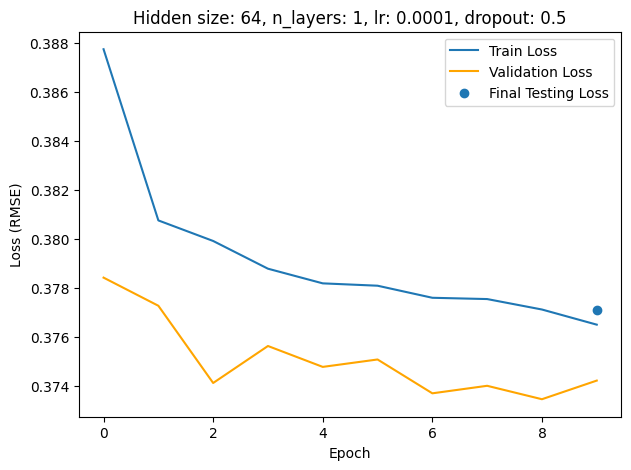

In [555]:
# Initialize the model and move it to the appropriate device
hidden_size = 64
n_layers = 1
lr = 0.0001
rnn_dropout = 0.5

# Initialize model
input_size = train_dataloader.dataset[0][0].size()[1]
RNN_model = BaseballRNN_test(input_size=input_size, output_size=1, hidden_size=hidden_size,
                            fc_hidden_size=hidden_size, n_layers=n_layers, rnn_type=rnn_type,
                            hidden_init='rand', rnn_dropout=rnn_dropout).to(DEVICE)

# Print trainable parameters
trainable_params = sum(p.numel() for p in RNN_model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Define the loss function and optimizer
optimizer = torch.optim.Adam(RNN_model.parameters(), lr=lr)

# Training loop
num_epochs = 10
log = []
eval_log = []


# Training loop
pbar = tqdm(range(num_epochs), desc="Training RNN")
for epoch in pbar:

    # Get average loss over batches for training
    avg_train_loss = train_model(RNN_model, optimizer, train_dataloader, DEVICE)
    log.append(avg_train_loss)
    avg_valid_loss = evaluate_model_RSME(RNN_model, valid_dataloader, DEVICE)
    eval_log.append(avg_valid_loss)

    pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss})

# Final output
test_accuracy_RSME = evaluate_model_RSME(RNN_model, test_dataloader, DEVICE)
test_accuracy_MAE = evaluate_model_MAE(RNN_model, test_dataloader, DEVICE)

print(f'Test RMSE: {test_accuracy_RSME:.4f}, Test MAE: {test_accuracy_MAE:.4f}')


# Plot loss over time
plt.figure(figsize=(7, 5))
plt.title(f'Hidden size: {hidden_size}, n_layers: {n_layers}, lr: {learning_rate}, dropout: {rnn_dropout}')
plt.ylabel('Loss (RMSE)')
plt.xlabel('Epoch')
plt.plot(log, label='Train Loss')
plt.plot(eval_log, label='Validation Loss', color='orange')
plt.scatter(x=epoch, y=test_accuracy_RSME, label='Final Testing Loss')
plt.legend()

plt.show()

Showing effect of dropout on final model performance

In [496]:
# Initialize the model and move it to the appropriate device
hidden_size = 64
n_layers = 1
lr = 0.0001

dropout_tests = [0.0, 0.2, 0.3, 0.4, 0.5]
dropout_losses = {dp: [[], []] for dp in dropout_tests}

for rnn_dropout in dropout_tests:

    # Initialize model
    input_size = train_dataloader.dataset[0][0].size()[1]
    RNN_model = BaseballRNN_test(input_size=input_size, output_size=1, hidden_size=hidden_size,
                                fc_hidden_size=hidden_size, n_layers=n_layers, rnn_type='GRU',
                                hidden_init='zero', rnn_dropout=rnn_dropout).to(DEVICE)

    # Define the loss function and optimizer
    optimizer = torch.optim.Adam(RNN_model.parameters(), lr=lr)

    # Training loop
    num_epochs = 30
    log = []
    eval_log = []


    # Training loop
    pbar = tqdm(range(num_epochs), desc=f"Training RNN ({rnn_dropout})")
    for epoch in pbar:

        # Get average loss over batches for training
        avg_train_loss = train_model(RNN_model, optimizer, train_dataloader, DEVICE)
        #log.append(avg_train_loss)
        avg_valid_loss = evaluate_model_RSME(RNN_model, valid_dataloader, DEVICE)
        #eval_log.append(avg_valid_loss)
        dropout_losses[rnn_dropout][0].append(avg_train_loss)
        dropout_losses[rnn_dropout][1].append(avg_valid_loss)

        pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss})


Training RNN (0.0):   0%|          | 0/30 [00:02<?, ?it/s]


KeyboardInterrupt: 

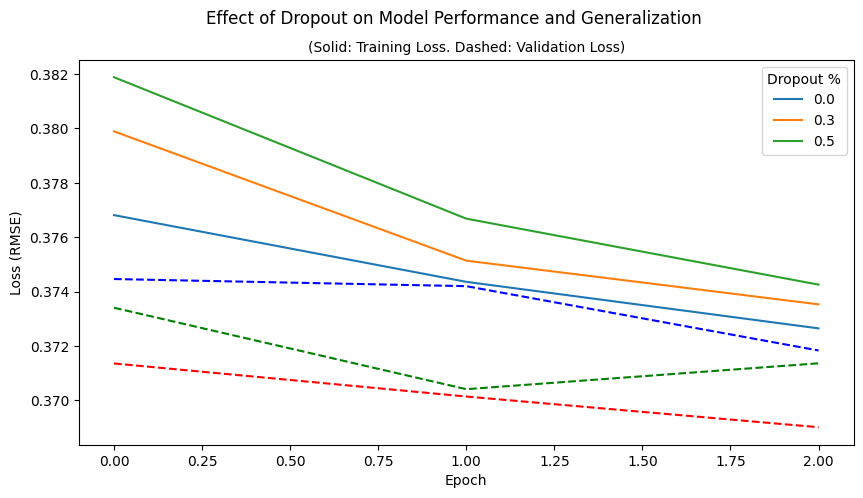

In [495]:
# Plot loss over time
plt.figure(figsize=(10, 5))
plt.suptitle(f'Effect of Dropout on Model Performance and Generalization', fontsize=12)
plt.title(f'(Solid: Training Loss. Dashed: Validation Loss)', fontsize=10)
plt.ylabel('Loss (RMSE)')
plt.xlabel('Epoch')
colors = ['r', 'g', 'b', 'y', 'c']
for i, dp in enumerate(dropout_tests):
    plt.plot(dropout_losses[dp][0], label=dp, linestyle='solid')
    plt.plot(dropout_losses[dp][1], linestyle='dashed', c=colors[i])
plt.legend(title='Dropout %', loc='upper right')

plt.show()